**<font color="#00dddd">
C'est en faisant n'importe quoi qu'on devient n'importe qui
只有做任何事，你才会成为任何人。
</font><br />**

# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
import copy
from sklearn import metrics

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 使用CPU
from keras.models import Sequential  # keras==2.6.0 自动安装的2.7版本有点问题
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
import tensorflow as tf
from keras.layers import Dropout

%matplotlib inline

# 调整增加输出窗口显示数据
np.set_printoptions(precision=4, threshold=8, edgeitems=4, linewidth=75, suppress=True, nanstr='nan', infstr='inf')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

# load data
root = 'D:/storage_hot/data/kaggle dataset/Wind Turbine/Wind Turbine Scada Dataset/archive/'
file = 'T1.csv'
data = pd.read_csv(root + file, index_col=False)  # encoding='GB18030'识别汉字表头；index_col=False 使得pandas不用第一列做索引（行名）
data

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  Wind Direction (°)
0      01 01 2018 00:00           380.047791          5.311336                     416.328908          259.994904
1      01 01 2018 00:10           453.769196          5.672167                     519.917511          268.641113
2      01 01 2018 00:20           306.376587          5.216037                     390.900016          272.564789
3      01 01 2018 00:30           419.645905          5.659674                     516.127569          271.258087
4      01 01 2018 00:40           380.650696          5.577941                     491.702972          265.674286
...                 ...                  ...               ...                            ...                 ...
50525  31 12 2018 23:10          2963.980957         11.404030                    3397.190793           80.502724
50526  31 12 2018 23:20          1684.353027          7.332648                    1173.055771           84.062599
50527  31 12 2018 23:30          2201.106934          8.435358                    1788.284755           84.742500
50528  31 12 2018 23:40          2515.694092          9.421366                    2418.382503           84.297913
50529  31 12 2018 23:50          2820.466064          9.979332                    2779.184096           82.274620

[50530 rows x 5 columns]

In [2]:
# rename columes
data.columns = ['Date', 'Active-Power(kW)', 'Wind-Speed(m/s)', 'Theoretical-P(kW)', 'Wind-Dir']

In [3]:
# Data description
data.describe()

Active-Power(kW)  Wind-Speed(m/s)  Theoretical-P(kW)      Wind-Dir
count      50530.000000     50530.000000       50530.000000  50530.000000
mean        1307.684332         7.557952        1492.175463    123.687559
std         1312.459242         4.227166        1368.018238     93.443736
min           -2.471405         0.000000           0.000000      0.000000
25%           50.677890         4.201395         161.328167     49.315437
50%          825.838074         7.104594        1063.776283     73.712978
75%         2482.507568        10.300020        2964.972462    201.696720
max         3618.732910        25.206011        3600.000000    359.997589

In [4]:
# 显示有空值的条目
data[data.isnull().T.any()]

Empty DataFrame
Columns: [Date, Active-Power(kW), Wind-Speed(m/s), Theoretical-P(kW), Wind-Dir]
Index: []

# 原始数据分析

## 风速和输出功率变化曲线

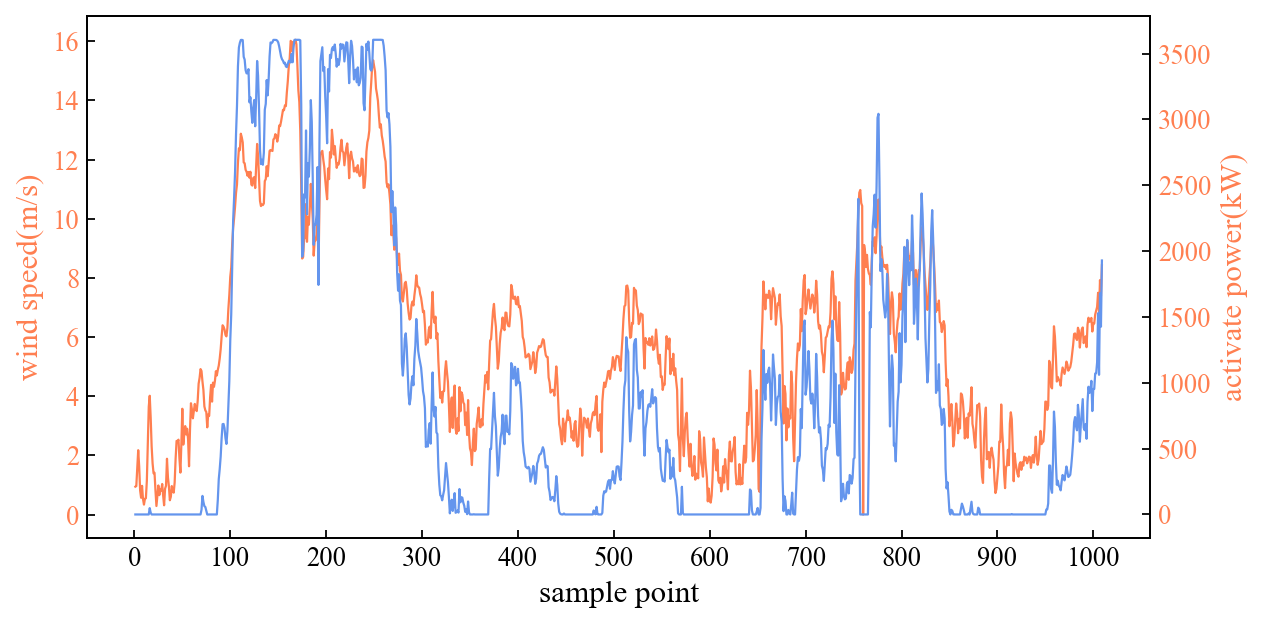

In [5]:
# 绘制双 y 轴折线图
def plot_twin(array1, array2, start=1, end=10, xlab='sample point', ylab1='array1', ylab2='array2'):
    num = np.array(range(end - start + 1)) + 1  # x轴坐标刻度，从1开始计数

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置字体---'Microsoft YaHei'
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    fig, ax1 = plt.subplots(figsize=(8, 4), dpi=160)

    if int((end-start+1) / 10) > 10:
        x_major_locator = plt.MultipleLocator(int((end - start + 1) / 10))  # MultipleLocator()函数设置了x轴相邻显示点的间隔
        ax = plt.gca()
        ax.xaxis.set_major_locator(x_major_locator)

    colors = ['coral', 'cornflowerblue']
    ax1.set_xlabel(xlab, fontsize=14)  # 设置 x 轴标签、字体大小
    ax1.tick_params(axis='x', labelsize=12)  # x 轴刻度值大小
    ax1.set_ylabel(ylab1, color=colors[0], fontsize=14)  # 设置第 1 个 y 轴特征标签字体颜色、大小
    ax1.tick_params(axis='y', labelcolor=colors[0], labelsize=12)  # 第 1 个 y 轴刻度值字体颜色大小
    ax1.plot(num, array1[start - 1:end], color=colors[0], linewidth=1)  # 输入数据绘制第 1 个 y 轴折线图、设置折线颜色

    ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

    ax2.set_ylabel(ylab2, color=colors[0], fontsize=14)  # 设置第 2 个 y 轴特征标签字体颜色、大小
    ax2.tick_params(axis='y', labelcolor=colors[0], labelsize=12)  # 第 2 个 y 轴刻度值字体颜色、大小
    ax2.plot(num, array2[start - 1:end], color=colors[1], linewidth=1)  # 输入数据绘制第 2 个 y 轴折线图、设置折线颜色

    fig.tight_layout()  #自动调整子图间距
    plt.savefig(r'D:/storage_hot/project/output/wind-turbine/windspeed-power.png', dpi=300)

plot_twin(data['Wind-Speed(m/s)'], data['Active-Power(kW)'], 6*24*5, 6*24*12,
          xlab='sample point', ylab1='wind speed(m/s)', ylab2='activate power(kW)')

## 参数分布情况

### 风速大小数值分布情况

<function matplotlib.pyplot.show(close=None, block=None)>

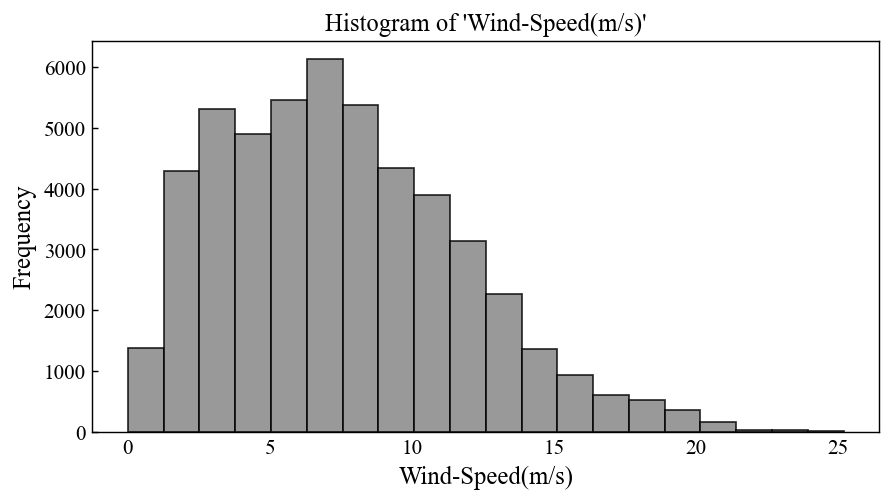

In [6]:
# 风速分布直方图
def plot_histogram(x):
    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.major.width'] = '0'  # 刻度值标记点宽度
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置字体---'Microsoft YaHei'
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    
    plt.figure(figsize=(8, 4),dpi=127)
    plt.hist(x, bins = 20, alpha=0.8, color = 'gray', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name), fontsize=14)
    plt.xlabel("{var_name}".format(var_name=x.name), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.tick_params(labelsize=12)  # 轴上刻度值字体大小


plot_histogram(data['Wind-Speed(m/s)'])
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/hist-windspeed.png', dpi=300)
plt.show

### 风机实际输出功率的数值分布情况

<function matplotlib.pyplot.show(close=None, block=None)>

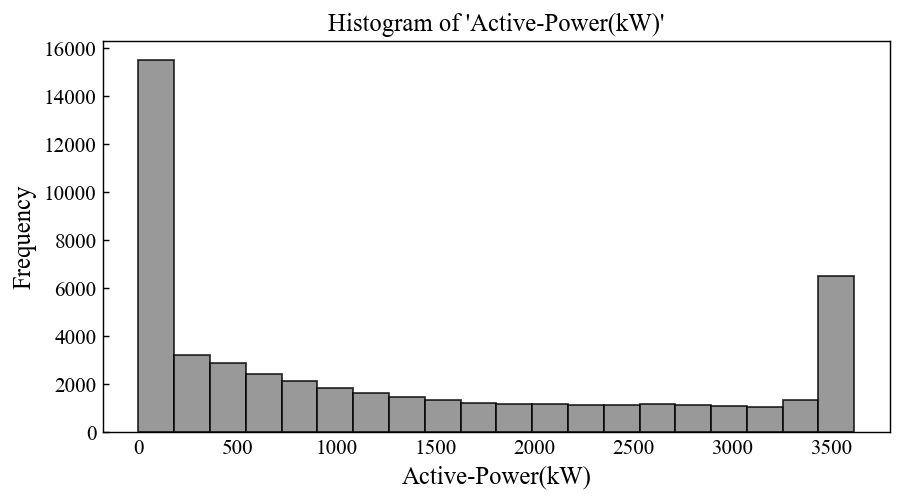

In [7]:
# 风力机组输出功率分布直方图
plot_histogram(data['Active-Power(kW)'])
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/hist-activepower.png', dpi=300)
plt.show

### 数据样本中风向分布情况

<function matplotlib.pyplot.show(close=None, block=None)>

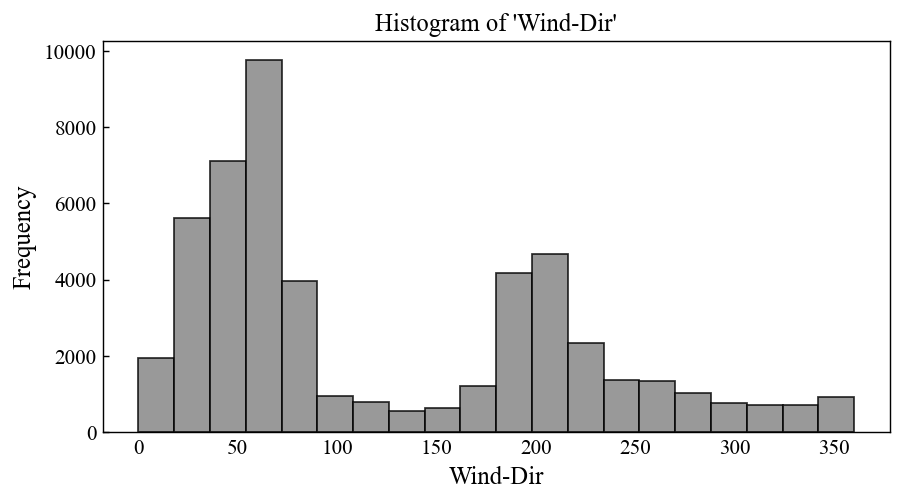

In [8]:
# 风向分布直方图
plot_histogram(data['Wind-Dir'])
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/hist-wind-dir.png', dpi=300)
plt.show

### 特征参数的月份分布情况

In [9]:
# 按月份切割数据
a_p = pd.DataFrame()
for i in np.array(range(12)):
    a_p[str(i)]=data.iloc[i*6*24*29:(i+1)*6*24*29,1].values
a_p

0            1            2           3            4            5            6           7            8            9           10           11
0      380.047791  3602.425049  3543.438965    0.000000     0.000000  2651.013916  1067.973999    0.000000   223.919205  1481.727051  3603.073975  3600.434082
1      453.769196  3602.739014  1878.557983  160.827606     0.000000  2659.680908  1112.161987    0.000000   238.311707  1479.456055  3603.288086  3600.542969
2      306.376587  3602.092041   285.655609  165.462799     0.000000  2552.315918  1083.482056    0.000000   342.585602  1233.536987  3603.354980  3600.374023
3      419.645905  3602.476074    81.741623  961.088989     0.000000  2045.550049   888.525208    0.000000   343.905396  1219.068970  3603.191895  3600.152100
4      380.650696  3602.541992   116.363701  482.786591    63.100479  1933.964966   829.155823    0.000000   356.419495  1117.761963  3603.397949  3600.052979
...           ...          ...          ...         ...          ...          ...          ...         ...          ...          ...          ...          ...
4171  3603.023926  3527.047119     0.000000    0.000000  3236.854004  1476.828003     0.000000   52.776711  1395.156006  3602.093994  3600.412109   724.054016
4172  3602.831055  3488.284912     0.000000    0.000000  2926.347900  1001.348022     0.000000   97.112511  1810.885010  3596.356934  3568.322998   727.238525
4173  3602.445068  3484.428955     0.000000    0.000000  2825.024902   630.353577     0.000000   86.994522  1474.530029  3601.780029  3600.440918   886.928284
4174  3602.764893  3521.846924     0.000000    0.000000  2629.183105   823.223877     0.000000  249.765793  1493.302002  3601.104004  3599.964111   824.530029
4175  3602.769043  3510.097900     0.000000    0.000000  2446.688965  1270.857056     0.000000  255.598007  1657.930054  3602.335938  3600.343018   808.012878

[4176 rows x 12 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

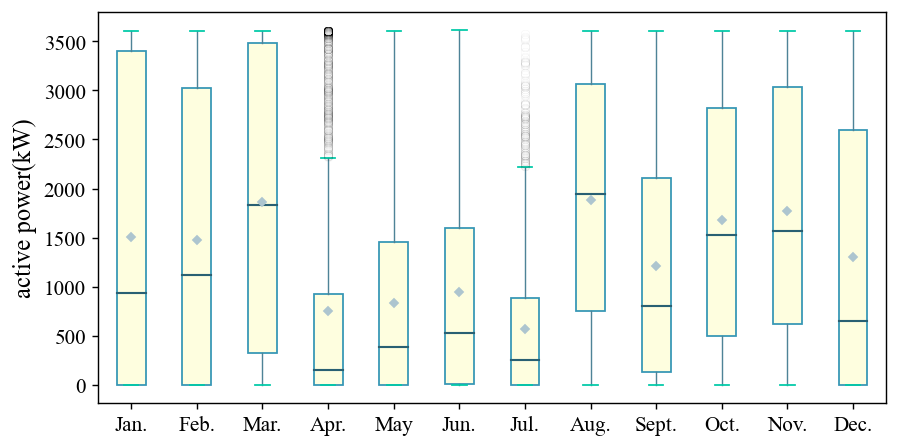

In [10]:
colors = ["#3596B5", "#FEFEDF", "#296073", "#ADC5CF", "#4E8397", "#00C9A7"]  # 0箱体边框、1箱体填充、2中位数线、3均值点、4须、5极值线、

matplotlib.rcdefaults()  # 将配置重置为默认值
plt.rcParams['xtick.direction'] = 'out'  # 设置xtick方向：in、out、inout
plt.rcParams['ytick.direction'] = 'out'  # 设置ytick方向：in、out、inout
plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置字体---'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['savefig.dpi'] = 300  # 图片像素
# plt.rcParams['figure.dpi'] = 300  # 分辨率

plt.figure(figsize=(8, 4),dpi=127) # 创建画板
plt.boxplot(a_p,
            widths=0.44,  # 箱体边框宽度
            labels=['Jan.','Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.'],
            patch_artist=True, boxprops={'color':colors[0], 'facecolor':colors[1], 'linewidth':1},  # 箱体边框颜色；箱体填充色；箱体框线粗细 lightblue
            medianprops=dict(color=colors[2], linewidth=1.2),  # 中位数线颜色、粗细
            showmeans=True, meanprops={'color':colors[3], 'markeredgecolor':colors[3], 'markerfacecolor':colors[3], 'marker':'D','markersize':3},  # 均值点标记
            whiskerprops=dict(color=colors[4], linewidth=.8),  # 须的颜色、粗细
            showcaps=True, capprops={'color':colors[5], 'linewidth':1},  # 极值线颜色、粗细
            showfliers=True, flierprops={'color':'b', 'linewidth':100, 'markeredgewidth':0.01, 'markersize':5})  # 异常值点设置, sym = '*', 'markeredgewidth':标记点轮廓线粗细, 'markersize':标记点大小

# plt.title('Examples of boxplot', fontsize=20)  # 标题，并设定字号大小
plt.tick_params(labelsize=12)  # 刻度值大小
# plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.ylabel('active power(kW)', fontsize=14)  # 设置 y 轴标签文字、大小
plt.xlabel('', fontsize=14)  # 设置 x 轴标签文字、大小
# plt.xticks(rotation=0)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/active-power月份散布.png', dpi=300)
plt.show

## 特征相关性分析

### 特征参数主成分分析PCA

<function matplotlib.pyplot.show(close=None, block=None)>

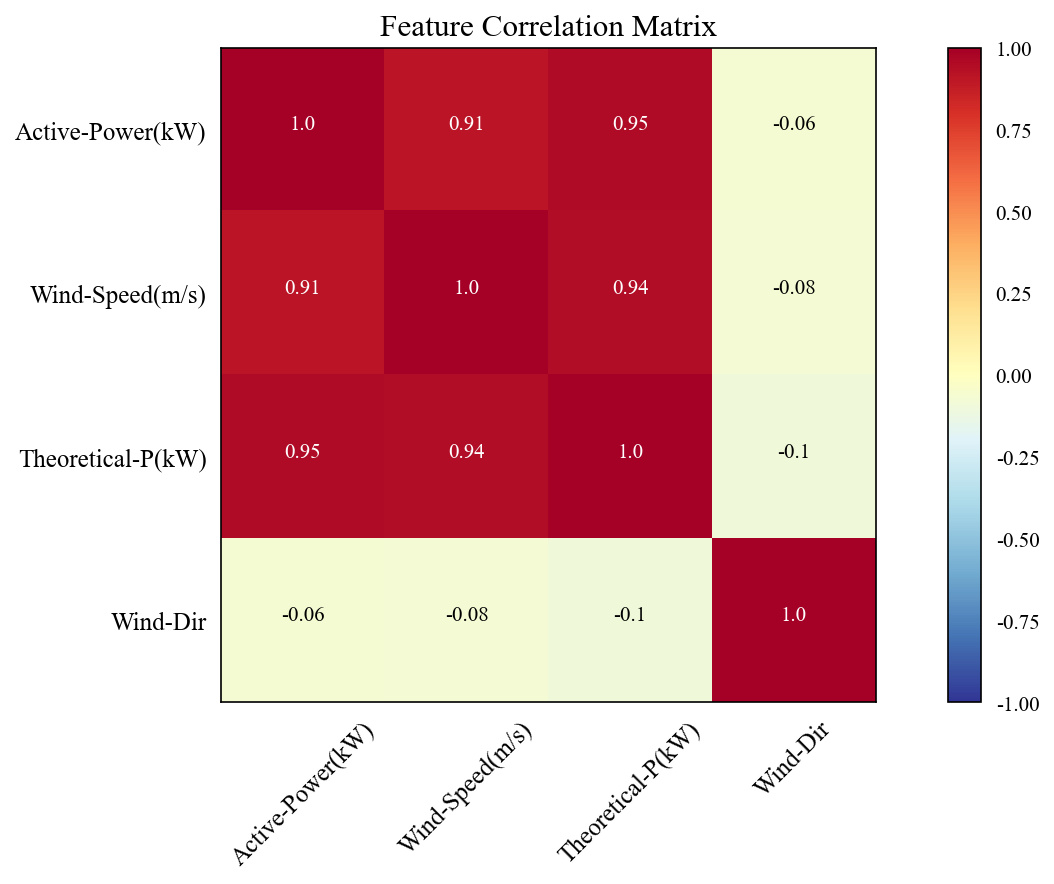

In [11]:
def pic_heatmap(data):
    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['xtick.major.width'] = '0'
    plt.rcParams['ytick.major.width'] = '0'
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置字体---'Microsoft YaHei'
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    
    X = StandardScaler().fit_transform(data.values)  # 数据标准化
    feature_names = list(data.columns)  # 获取变量名列表
    plt.figure(figsize=(10, 6),dpi=150)  # 创建画板设置比例像素
    ax = plt.axes()
    im = ax.imshow(np.corrcoef(X.T), cmap="RdYlBu_r", vmin=-1, vmax=1)  # 计算相关系数矩阵
    ax.set_xticks(np.array(range(0,len(feature_names))))  # 设置 x 轴坐标点刻度数量
    ax.set_xticklabels(list(feature_names), rotation=45)  # 设置 x 轴坐标点刻度标签、及其旋转角度
    ax.set_yticks(np.array(range(0,len(feature_names))))  # 设置 y 轴坐标点刻度数量
    ax.set_yticklabels(list(feature_names))  # 设置 y 轴坐标点刻度标签
    for i in np.array(range(X.shape[1])):  # 行
        for j in np.array(range(X.shape[1])):  # 列
            plt.text(j, i, round(np.corrcoef(X.T)[i,j],2),
                     horizontalalignment="center",
                     color="white" if abs(np.corrcoef(X.T)[i,j]) > 0.5 else "black")  # 列，行， 值
    plt.colorbar(im).ax.set_ylabel("", rotation=0)  # 设置比色卡位置、标签、标签角度 "$r$"
    ax.set_title("Feature Correlation Matrix", fontsize=15)
    plt.tick_params(labelsize=12)  # 刻度值大小
    plt.tight_layout()
    
    
pic_heatmap(data.loc[:,['Active-Power(kW)', 'Wind-Speed(m/s)', 'Theoretical-P(kW)', 'Wind-Dir']])
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/pca.png', dpi=300)
plt.show

### 特征散布矩阵

In [12]:
data_=data[:10000]
data_.shape

(10000, 5)

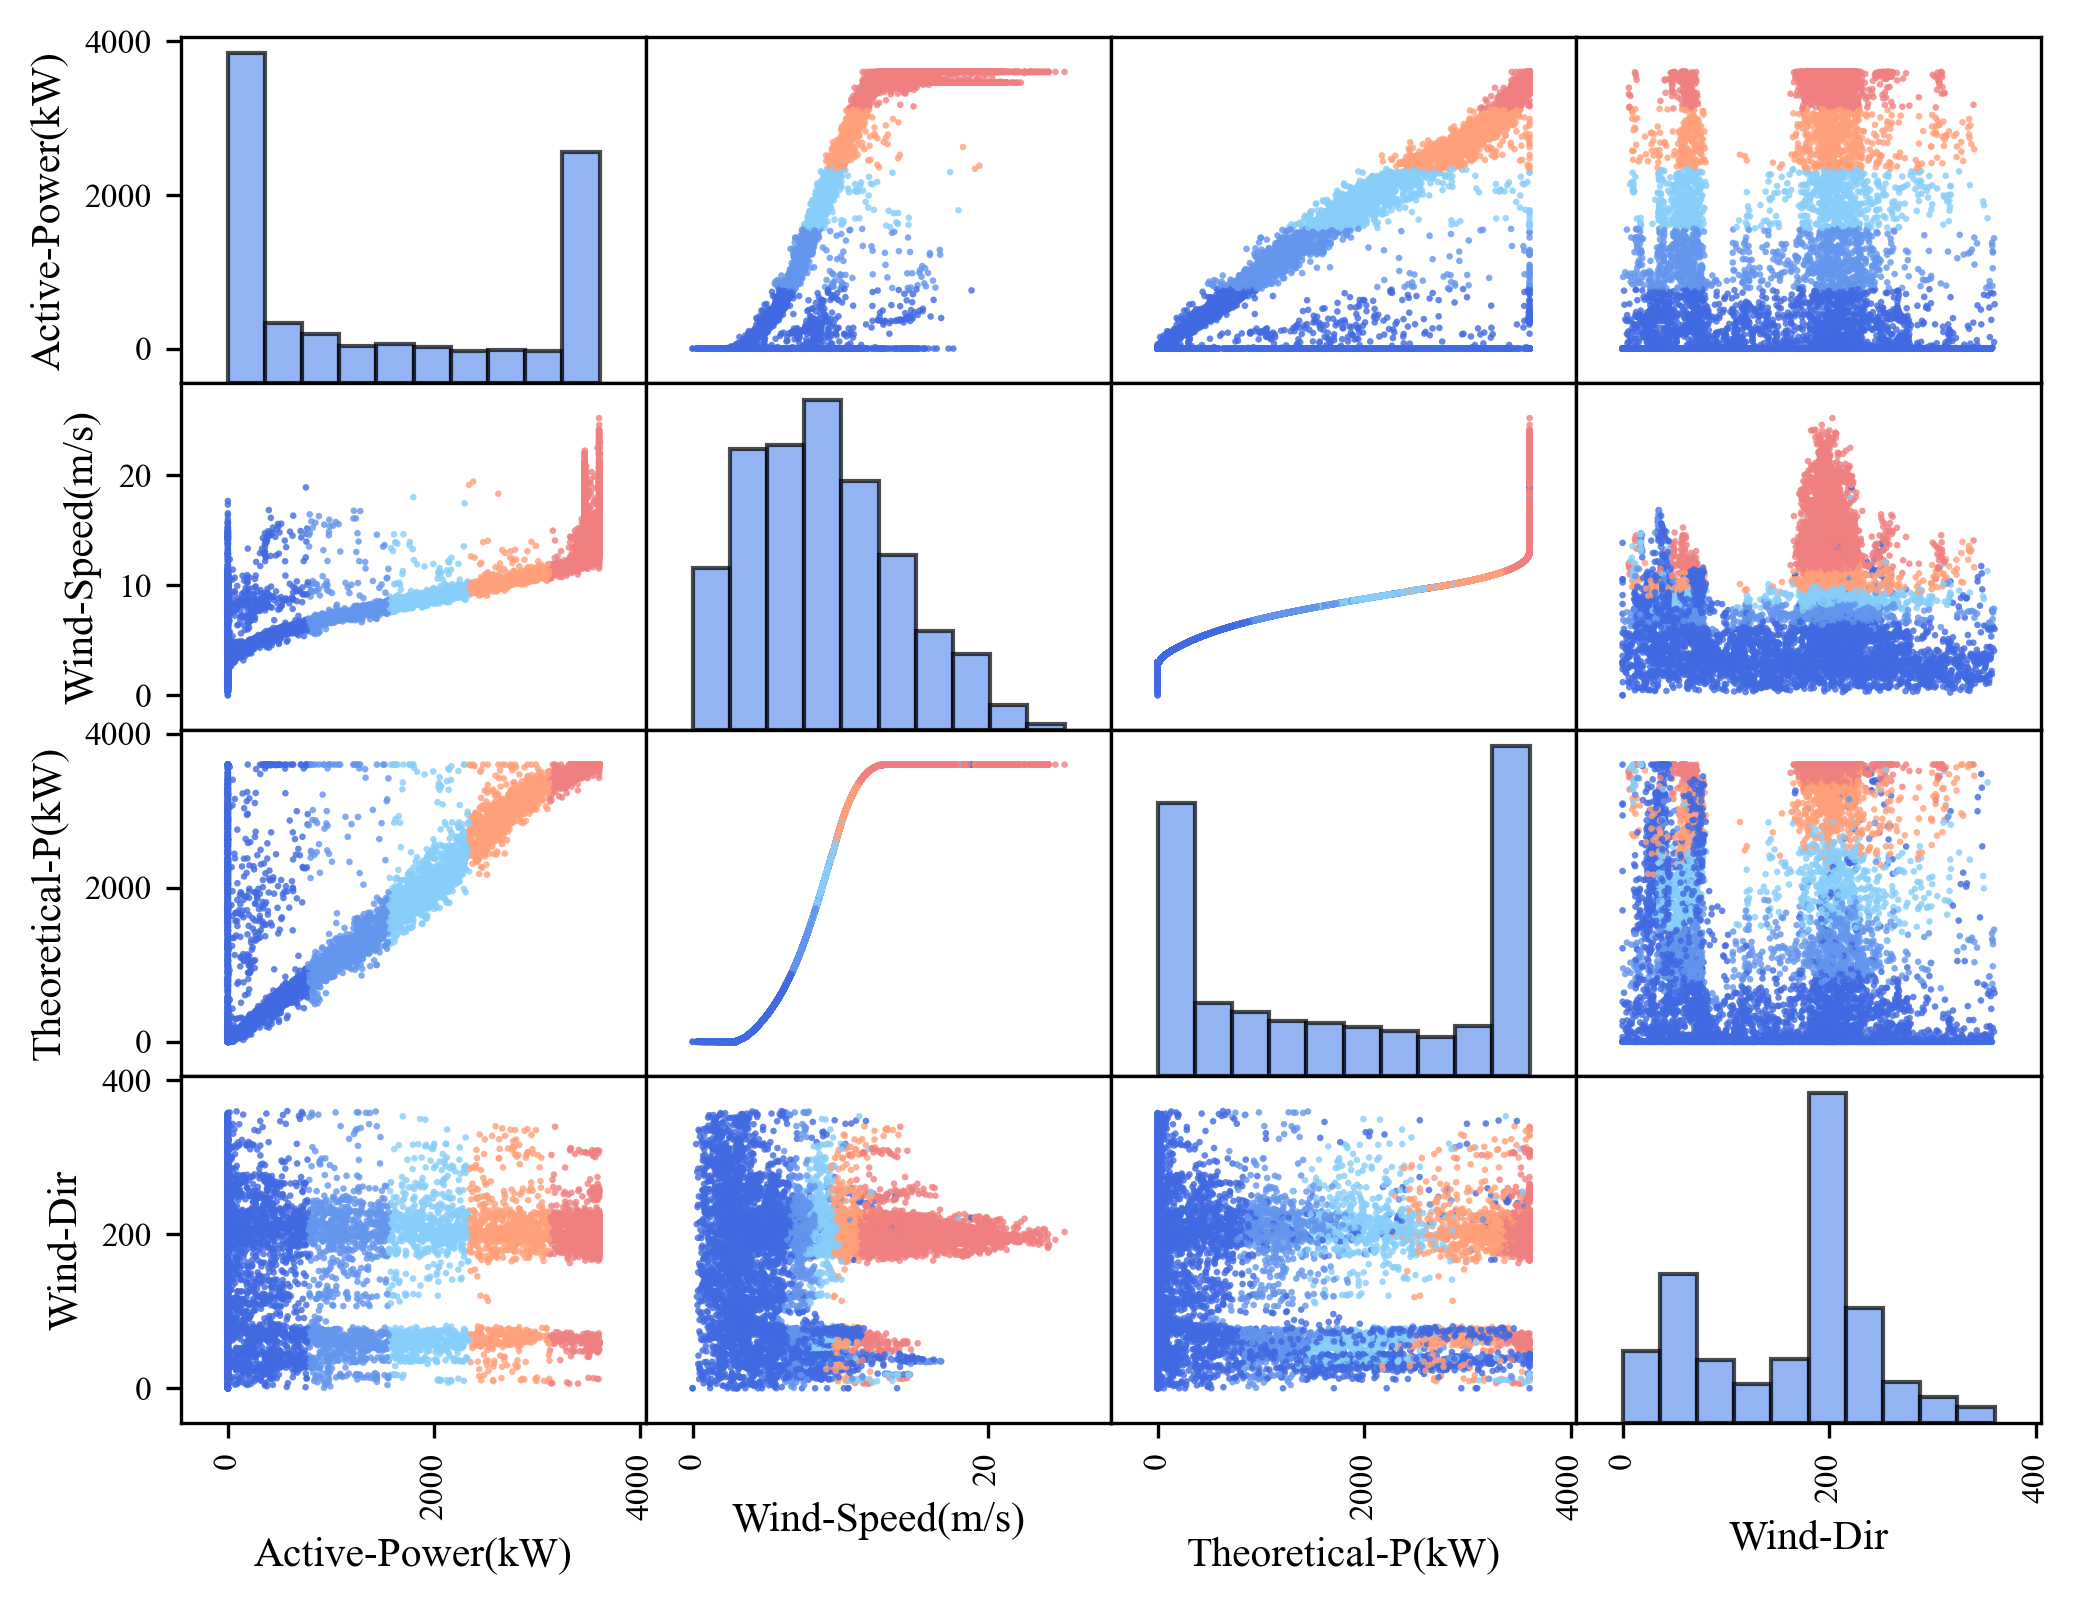

In [13]:
matplotlib.rcdefaults()  # 将配置重置为默认值
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'  # 设置ytick方向：in、out、inout
plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置字体---'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
plt.rcParams['figure.dpi'] = 300  # 分辨率
plt.rcParams['font.size'] = 10  # 字体大小
# plt.rcParams['ytick.labelsize'] = 'larger'  # xx-small, x-small, small, medium, large, x-large, xx-large, smaller, larger
# plt.rcParams[''] = 'larger'

colors=['royalblue', 'cornflowerblue', 'lightskyblue', 'lightsalmon', 'lightcoral']
pd.plotting.scatter_matrix(data_.loc[:,['Active-Power(kW)', 'Wind-Speed(m/s)', 'Theoretical-P(kW)', 'Wind-Dir']],
                           alpha=0.8, figsize=(8,6), s=10,
                           diagonal='hist', hist_kwds={'color': 'cornflowerblue', 'edgecolor': 'black', 'alpha': 0.7},
                           range_padding=0.25,  # 与坐标轴之间留白区域大小
                           color=data_['Active-Power(kW)'].apply(lambda x : colors[int(x/780)]),
                           
                          )  # color=data1['I'].apply(lambda x : colors[x]);;;colors[4]
# plt.tick_params(labelsize=12)  # 轴上刻度值字体大小
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/scatter-matrix.png', dpi=300)
plt.show()

## 时间序列特性分析

### 时滞图

In [139]:
data_=data[:10000]
data_.shape

(10000, 5)

In [15]:
data_.describe()

Active-Power(kW)  Wind-Speed(m/s)  Theoretical-P(kW)      Wind-Dir
count      10000.000000     10000.000000       10000.000000  10000.000000
mean        1532.505863         8.857273        1846.123174    160.961728
std         1460.971414         4.997151        1446.889415     81.467585
min           -2.471405         0.000000           0.000000      0.000000
25%            0.000000         4.807374         290.049790     73.489996
50%         1098.852478         8.431045        1785.646466    191.515457
75%         3329.592346        12.120265        3539.425334    211.703171
max         3605.758057        25.206011        3600.000000    359.905914

#### 单个时滞图

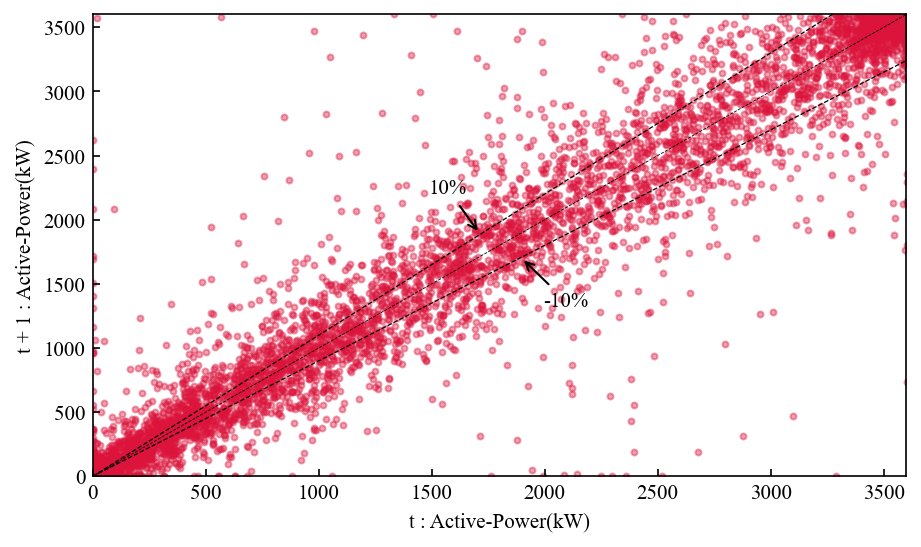

In [140]:

def time_delay(x):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("t : "+"{var_name}".format(var_name=x.name))
    plt.ylabel("t + 1 : "+"{var_name}".format(var_name=x.name))
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(x[0:len(x)-4], x[1:len(x)-3], s=area, c=colors[1], alpha=0.4, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
time_delay(data_['Active-Power(kW)'])
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/时滞图.png', dpi=300)
plt.show()

#### 多个时滞图

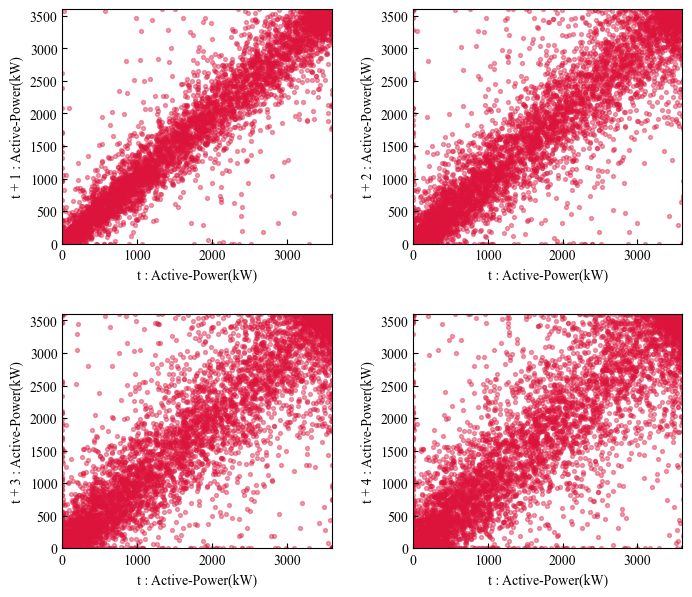

In [20]:

def time_delay(x):
    yy = 3600
    colors = ['#00CED1', '#DC143C']  #点的颜色
    
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'
    
    fig, axes = plt.subplots(2,2,figsize=(8,7), dpi= 100)
    
    plt.subplot(221)
    area = 8  # 点面积 
    plt.xlabel("t : "+"{var_name}".format(var_name=x.name))
    plt.ylabel("t + 1 : "+"{var_name}".format(var_name=x.name))
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-4], x[1:len(x)-3], s=area, c=colors[1], alpha=0.4, label='类别A')
    
    plt.subplot(222)
    area = 8  # 点面积 
    plt.xlabel("t : "+"{var_name}".format(var_name=x.name))
    plt.ylabel("t + 2 : "+"{var_name}".format(var_name=x.name))
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-4], x[2:len(x)-2], s=area, c=colors[1], alpha=0.4, label='类别A')
    
    plt.subplot(223)
    area = 8  # 点面积 
    plt.xlabel("t : "+"{var_name}".format(var_name=x.name))
    plt.ylabel("t + 3 : "+"{var_name}".format(var_name=x.name))
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-4], x[3:len(x)-1], s=area, c=colors[1], alpha=0.4, label='类别A')
    
    plt.subplot(224)
    area = 8  # 点面积 
    plt.xlabel("t : "+"{var_name}".format(var_name=x.name))
    plt.ylabel("t + 4 : "+"{var_name}".format(var_name=x.name))
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)
    plt.scatter(x[0:len(x)-4], x[4:len(x)], s=area, c=colors[1], alpha=0.4, label='类别A')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
time_delay(data_['Active-Power(kW)'])
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/时滞图2.png', dpi=300)
plt.show()

### 时间序列的自相关和偏自相关函数计算

In [21]:
data_=data[:10000]
data_.shape

(10000, 5)

C:\Users\Administrator\Desktop\env37_1\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


<function matplotlib.pyplot.show(close=None, block=None)>

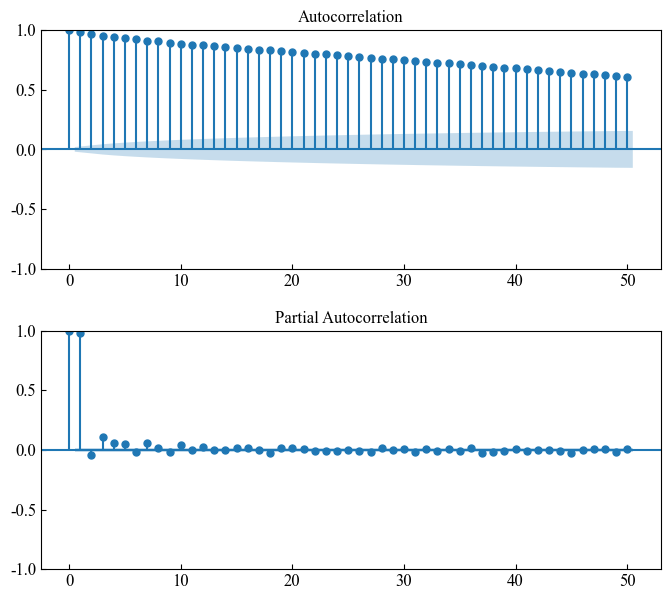

In [22]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(data_['Active-Power(kW)'].values, nlags=50)
# pacf_50 = pacf(data_['Active-Power(kW)'].values, nlags=50)
# print(acf_50, pacf_50)

matplotlib.rcdefaults()  # 将配置重置为默认值
plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置字体---'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['font.size'] = 12  # 字体大小

fig, axes = plt.subplots(2,1,figsize=(8,7), dpi= 100)

plt.subplot(211)
plot_acf(data_['Active-Power(kW)'].values, lags=50, ax=axes[0])
plt.tick_params(labelsize=12)  # 刻度值大小

plt.subplot(212)
plot_pacf(data_['Active-Power(kW)'].values, lags=50, ax=axes[1])
plt.tick_params(labelsize=12)  # 刻度值大小


plt.subplots_adjust(hspace=0.26)  # 子图间距调整
# fig.tight_layout()  #自动调整子图间距

plt.savefig(r'D:/storage_hot/project/output/wind-turbine/自相关&偏自相关.png', dpi=300)
plt.show

# 数据预处理

## 对数据进行归一化或标准化处理

In [5]:
data

Date  Active-Power(kW)  Wind-Speed(m/s)  Theoretical-P(kW)    Wind-Dir
0      01 01 2018 00:00        380.047791         5.311336         416.328908  259.994904
1      01 01 2018 00:10        453.769196         5.672167         519.917511  268.641113
2      01 01 2018 00:20        306.376587         5.216037         390.900016  272.564789
3      01 01 2018 00:30        419.645905         5.659674         516.127569  271.258087
4      01 01 2018 00:40        380.650696         5.577941         491.702972  265.674286
...                 ...               ...              ...                ...         ...
50525  31 12 2018 23:10       2963.980957        11.404030        3397.190793   80.502724
50526  31 12 2018 23:20       1684.353027         7.332648        1173.055771   84.062599
50527  31 12 2018 23:30       2201.106934         8.435358        1788.284755   84.742500
50528  31 12 2018 23:40       2515.694092         9.421366        2418.382503   84.297913
50529  31 12 2018 23:50       2820.466064         9.979332        2779.184096   82.274620

[50530 rows x 5 columns]

In [6]:
date_pre = data[['Wind-Speed(m/s)','Wind-Dir','Active-Power(kW)']]
date_pre

Wind-Speed(m/s)    Wind-Dir  Active-Power(kW)
0             5.311336  259.994904        380.047791
1             5.672167  268.641113        453.769196
2             5.216037  272.564789        306.376587
3             5.659674  271.258087        419.645905
4             5.577941  265.674286        380.650696
...                ...         ...               ...
50525        11.404030   80.502724       2963.980957
50526         7.332648   84.062599       1684.353027
50527         8.435358   84.742500       2201.106934
50528         9.421366   84.297913       2515.694092
50529         9.979332   82.274620       2820.466064

[50530 rows x 3 columns]

In [7]:
# 拟合计算放缩比例等参数，并存储在 scaler
scaler = MinMaxScaler(feature_range = (0,1)).fit(date_pre)    # 字典对象也可以

# 应用比例对原始数据进行转换
data_norm = scaler.transform(date_pre)

# 反转归一化
def inverse_transform_col(scaler, y, n_col):
    """
    scaler是对包含多个feature的X拟合的,y对应其中一个feature,n_col为y在X中对应的列编号.返回y的反归一化结果
    """
    y = y.copy()
    y -= scaler.min_[n_col]
    y /= scaler.scale_[n_col]
    return y

data_norm

array([[0.2107, 0.7222, 0.1056],
       [0.225 , 0.7462, 0.126 ],
       [0.2069, 0.7571, 0.0853],
       [0.2245, 0.7535, 0.1166],
       ...,
       [0.2909, 0.2335, 0.4658],
       [0.3347, 0.2354, 0.6085],
       [0.3738, 0.2342, 0.6954],
       [0.3959, 0.2285, 0.7796]])

## 检验归一化计算和反转过程是否准确

In [9]:
data_norm[:,2][:20]

array([0.1056, 0.126 , 0.0853, 0.1166, ..., 0.2059, 0.2073, 0.2041,
       0.2181])

<function matplotlib.pyplot.show(close=None, block=None)>

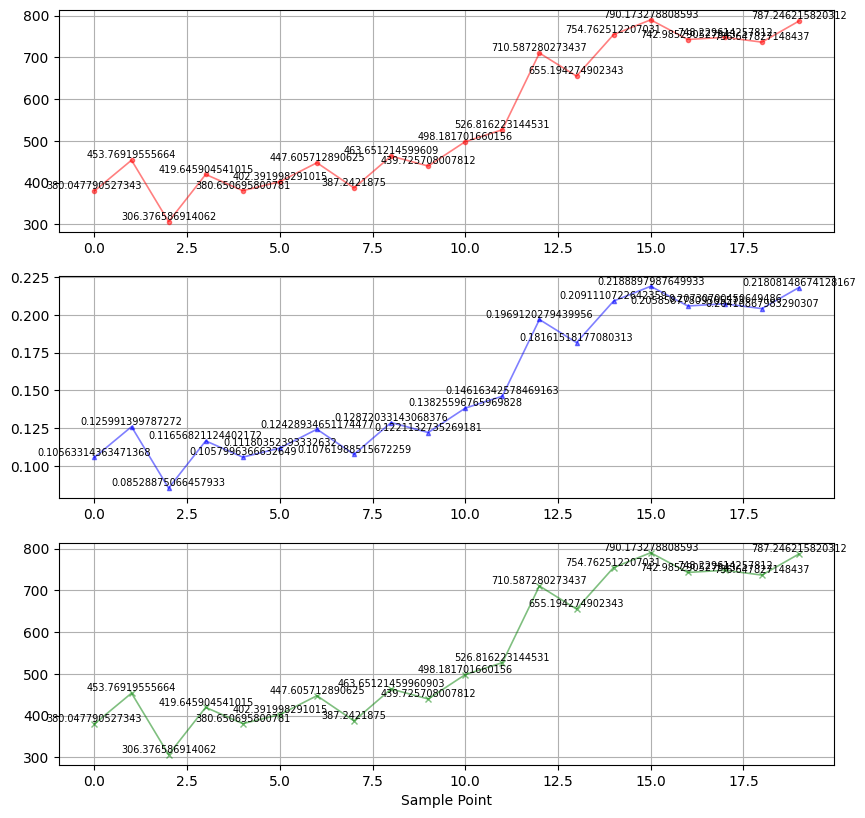

In [13]:
fig, axes = plt.subplots(3,1,figsize=(10,10), dpi= 100)

# 绘制原始数据
plt.subplot(311)
plt.plot(date_pre['Active-Power(kW)'][:20], c='r', alpha=0.5, label='原始数据', marker='o', markersize=3, linewidth=1.2)
plt.grid()  # 网格
for a, b in zip(np.array(range(0,len(date_pre['Active-Power(kW)'][:20]))), date_pre['Active-Power(kW)'][:20]):  # 设置数字标签
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)

# 绘制归一化的数据
plt.subplot(312)
plt.plot(data_norm[:,2][:20], c='b', alpha=0.5, label='normal数据', marker='^', markersize=3, linewidth=1.2)
plt.grid()  # 网格
for a, b in zip(np.array(range(0,len(data_norm[:,2][:20]))), data_norm[:,2][:20]):  # 设置数字标签
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
    
# 绘制反转归一化的数据
plt.subplot(313)
plt.plot(inverse_transform_col(scaler, data_norm[:,2], 2)[:20], c='g', alpha=0.5, label='inverse数据', marker='x', markersize=4, linewidth=1.2)
plt.xlabel('Sample Point')
plt.grid()  # 网格
for a, b in zip(np.array(range(0,len(inverse_transform_col(scaler, data_norm[:,2], 2)[:20]))), inverse_transform_col(scaler, data_norm[:,2], 2)[:20]):  # 设置数字标签
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)

plt.savefig(r'D:/storage_hot/project/output/wind-turbine/normal_inverse.png', dpi=300)
plt.show

## 时间序列转换为监督学习问题

In [8]:
# 时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# to supervised learning
n_timesteps = 10  # 之前的时刻数量
n_features = data_norm.shape[1]  # 数据集中输入特征数量
data_supervised = series_to_supervised(data_norm, n_timesteps, 1)  # 包含 t 时刻之前的 timestep 个时间点，以及 t 时刻数据，以 t 时刻为预测对象

data_supervised

var1(t-10)  var2(t-10)  var3(t-10)  var1(t-9)  var2(t-9)  var3(t-9)  var1(t-8)  var2(t-8)  var3(t-8)  var1(t-7)  var2(t-7)  var3(t-7)  var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
10       0.210717    0.722213    0.105633   0.225032   0.746230   0.125991   0.206936   0.757129   0.085289   0.224537   0.753500   0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113  0.227093  0.699591  0.138256
11       0.225032    0.746230    0.125991   0.206936   0.757129   0.085289   0.224537   0.753500   0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256  0.235428  0.737518  0.146163
12       0.206936    0.757129    0.085289   0.224537   0.753500   0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256   0.235428   0.737518   0.146163  0.259756  0.761763  0.196912
13       0.224537    0.753500    0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256   0.235428   0.737518   0.146163   0.259756   0.761763   0.196912  0.245963  0.740930  0.181615
14       0.221294    0.737989    0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256   0.235428   0.737518   0.146163   0.259756   0.761763   0.196912   0.245963   0.740930   0.181615  0.258089  0.741006  0.209111
...           ...         ...         ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...       ...       ...       ...
50525    0.336143    0.221389    0.501719   0.334580   0.222592   0.550872   0.395805   0.222450   0.706077   0.413268   0.223480   0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152  0.452433  0.223620  0.819189
50526    0.334580    0.222592    0.550872   0.395805   0.222450   0.706077   0.413268   0.223480   0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152   0.452433   0.223620   0.819189  0.290909  0.233509  0.465819
50527    0.395805    0.222450    0.706077   0.413268   0.223480   0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152   0.452433   0.223620   0.819189   0.290909   0.233509   0.465819  0.334657  0.235397  0.608521
50528    0.413268    0.223480    0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152   0.452433   0.223620   0.819189   0.290909   0.233509   0.465819   0.334657 

In [9]:
# drop columns we don't want to predict
relain = np.array([3])  # 保留第几个变量(从1计数)，即预测对象
data_supervised_droped = copy.deepcopy(data_supervised)  # 深拷贝则不会改变原始字典对象内容
remov = np.array([x for x in range(data_norm.shape[1])]) + n_timesteps*n_features  # t 时刻所有参数列序号
remov = np.delete(remov,relain-1)
data_supervised_droped.drop(data_supervised_droped.columns[remov], axis=1, inplace=True)  # 去掉输出当中不需要预测的参数列 [-1,-2,-3,-4,-5,-6]

data_supervised_droped

var1(t-10)  var2(t-10)  var3(t-10)  var1(t-9)  var2(t-9)  var3(t-9)  var1(t-8)  var2(t-8)  var3(t-8)  var1(t-7)  var2(t-7)  var3(t-7)  var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  var2(t-3)  var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  var3(t-1)   var3(t)
10       0.210717    0.722213    0.105633   0.225032   0.746230   0.125991   0.206936   0.757129   0.085289   0.224537   0.753500   0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113  0.138256
11       0.225032    0.746230    0.125991   0.206936   0.757129   0.085289   0.224537   0.753500   0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256  0.146163
12       0.206936    0.757129    0.085289   0.224537   0.753500   0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256   0.235428   0.737518   0.146163  0.196912
13       0.224537    0.753500    0.116568   0.221294   0.737989   0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256   0.235428   0.737518   0.146163   0.259756   0.761763   0.196912  0.181615
14       0.221294    0.737989    0.105800   0.222330   0.734946   0.111804   0.229826   0.739348   0.124289   0.210507   0.716531   0.107620   0.221559   0.704118   0.128720   0.219123   0.718682   0.122113   0.227093   0.699591   0.138256   0.235428   0.737518   0.146163   0.259756   0.761763   0.196912   0.245963   0.740930   0.181615  0.209111
...           ...         ...         ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...        ...       ...
50525    0.336143    0.221389    0.501719   0.334580   0.222592   0.550872   0.395805   0.222450   0.706077   0.413268   0.223480   0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152  0.819189
50526    0.334580    0.222592    0.550872   0.395805   0.222450   0.706077   0.413268   0.223480   0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152   0.452433   0.223620   0.819189  0.465819
50527    0.395805    0.222450    0.706077   0.413268   0.223480   0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152   0.452433   0.223620   0.819189   0.290909   0.233509   0.465819  0.608521
50528    0.413268    0.223480    0.741118   0.425044   0.224892   0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.947611   0.498261   0.223599   0.971152   0.452433   0.223620   0.819189   0.290909   0.233509   0.465819   0.334657   0.235397   0.608521  0.695394
50529    0.425044    0.224892    0.834630   0.402862   0.228710   0.765928   0.478761   0.227740   0.921321   0.483839   0.228364   0.954863   0.495616   0.228090   0.9

## 划分训练集和测试集\划分输入变量输出变量

In [10]:
# split into train and test sets
# ser_supervised_value = ser_supervised_droped.values
n_train_num = int(len(data_supervised_droped)*0.8)  # 规定训练集数据数量，要小于数据量总数，在后面设置reshape设置样本个数、时间步长要注意数量对应
train = data_supervised_droped.values[:n_train_num, :]  # 按行切片，从0到n-1行，也就是从头开始总共 n 行数据
test = data_supervised_droped.values[n_train_num:, :]  # 按行切片
# y = data_supervised_droped.values[:,n_timesteps*n_features][n_train_num:]  # 测试集的 y，用于后续结果比较

print('train 规格：', train.shape)  # train.shape[0], train.shape[1]
print('test 规格：', test.shape)  # test.shape[0], test.shape[1]

# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]  # 按列切片，从起始位置到-2列：-1列
X_test, y_test = test[:, :-1], test[:, -1]  # x 和 y 变量类型都是<class 'numpy.ndarray'>

print('X_train 规格：', X_train.shape)  # train_X.shape[0], train_X.shape[1]
print('y_train 规格：', y_train.shape)
print('X_test 规格：', X_test.shape)  # test_X.shape[0], test_X.shape[1]
print('y_test 规格：', y_test.shape)

train 规格： (40416, 31)
test 规格： (10104, 31)
X_train 规格： (40416, 30)
y_train 规格： (40416,)
X_test 规格： (10104, 30)
y_test 规格： (10104,)


## 将数据集重构为三维格式

In [33]:
# reshape input to be 3D [samples, timesteps, features] [样本数量(就是原二维矩阵行数)，时间步长，特征数量(参数种类)]
X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))  # 相当于将每一行变换成一个二维矩阵
X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))

print('train_X :\n', X_train, '\n')
print('X_test :\n', X_test, '\n')
print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

train_X :
 [[[0.2107 0.7222 0.1056]
  [0.225  0.7462 0.126 ]
  [0.2069 0.7571 0.0853]
  [0.2245 0.7535 0.1166]
  ...
  [0.2298 0.7393 0.1243]
  [0.2105 0.7165 0.1076]
  [0.2216 0.7041 0.1287]
  [0.2191 0.7187 0.1221]]

 [[0.225  0.7462 0.126 ]
  [0.2069 0.7571 0.0853]
  [0.2245 0.7535 0.1166]
  [0.2213 0.738  0.1058]
  ...
  [0.2105 0.7165 0.1076]
  [0.2216 0.7041 0.1287]
  [0.2191 0.7187 0.1221]
  [0.2271 0.6996 0.1383]]

 [[0.2069 0.7571 0.0853]
  [0.2245 0.7535 0.1166]
  [0.2213 0.738  0.1058]
  [0.2223 0.7349 0.1118]
  ...
  [0.2216 0.7041 0.1287]
  [0.2191 0.7187 0.1221]
  [0.2271 0.6996 0.1383]
  [0.2354 0.7375 0.1462]]

 [[0.2245 0.7535 0.1166]
  [0.2213 0.738  0.1058]
  [0.2223 0.7349 0.1118]
  [0.2298 0.7393 0.1243]
  ...
  [0.2191 0.7187 0.1221]
  [0.2271 0.6996 0.1383]
  [0.2354 0.7375 0.1462]
  [0.2598 0.7618 0.1969]]

 ...

 [[0.1025 0.4495 0.0007]
  [0.113  0.4657 0.0007]
  [0.0959 0.5925 0.0007]
  [0.1072 0.6873 0.0007]
  ...
  [0.1086 0.6796 0.0007]
  [0.0906 0.7163 0.0

# 训练模型

In [19]:
# 统计分析, MSE, RMSE, MAE, MAPE, SMAPE, R2
# MSE 均方误差、方差
def mse(y, yhat):
    return metrics.mean_squared_error(y, yhat)

# RMSE 均方根误差
def rmse(y, yhat):
    return np.sqrt(metrics.mean_squared_error(y, yhat))

# MAE 平均绝对误差
def mae(y, yhat):
    return metrics.mean_absolute_error(y, yhat)

# MAPE和SMAPE需要自己实现
# MAPE 平均绝对百分比误差
def mape(y, yhat):
    return np.mean(np.abs((yhat - y) / y)) * 100

# SMAPE
def smape(y, yhat):
    return 2.0 * np.mean(np.abs(yhat - y) / (np.abs(yhat) + np.abs(y))) * 100

# R2（R-Square）决定系数
def r2(y, yhat):
    return metrics.r2_score(y, yhat)

## naive forecast

### 模型设置

In [162]:
y_test_inverse = inverse_transform_col(scaler, y_test, 2)  # 实际值
prediction_naive = np.concatenate(([0],y_test_inverse[:len(y_test_inverse)-1]),axis=0)  # 用 t-1 时刻的真实值作为 t 时刻的预测值
y_test_inverse

array([   0.    ,    0.    ,    0.    ,    0.    , ..., 1684.353 ,
       2201.1069, 2515.6941, 2820.4661])

In [163]:
prediction_naive

array([   0.    ,    0.    ,    0.    ,    0.    , ..., 2963.981 ,
       1684.353 , 2201.1069, 2515.6941])

### 预测结果展示

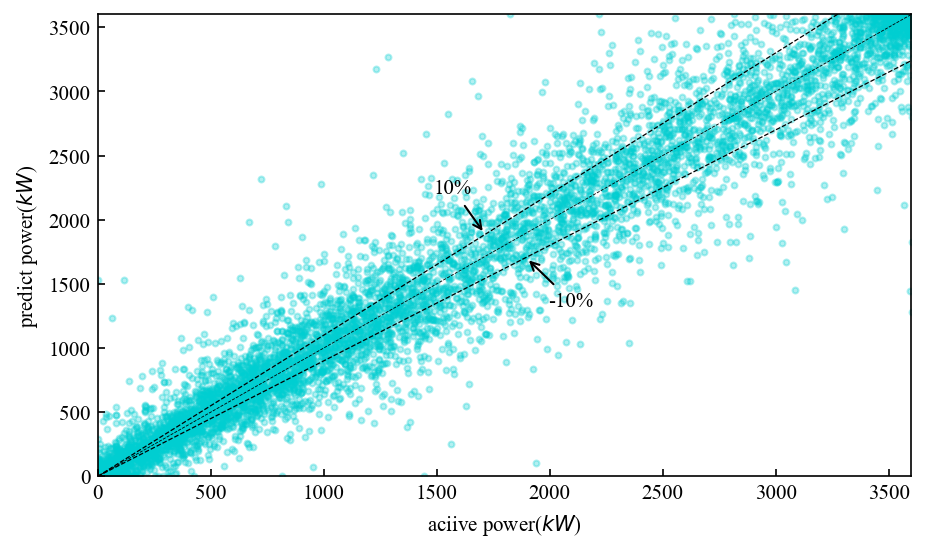

In [165]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("actual power($kW$)")
    plt.ylabel("predicted power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_naive)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/naive预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [164]:
print('mse:', mse(y_test_inverse,prediction_naive))
print('rmse', rmse(y_test_inverse,prediction_naive))
print('mae', mae(y_test_inverse,prediction_naive))
print('mape', mape(y_test_inverse,prediction_naive))
print('smape', smape(y_test_inverse,prediction_naive))
print('r2', r2(y_test_inverse,prediction_naive))

mse: 52174.91280570908
rmse 228.41828474469614
mae 126.431381686432
mape nan
smape nan
r2 0.9710303088384772


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


## XGBoost

### 模型训练

In [11]:
X_train

array([[0.2107, 0.7222, 0.1056, 0.225 , ..., 0.1287, 0.2191, 0.7187,
        0.1221],
       [0.225 , 0.7462, 0.126 , 0.2069, ..., 0.1221, 0.2271, 0.6996,
        0.1383],
       [0.2069, 0.7571, 0.0853, 0.2245, ..., 0.1383, 0.2354, 0.7375,
        0.1462],
       [0.2245, 0.7535, 0.1166, 0.2213, ..., 0.1462, 0.2598, 0.7618,
        0.1969],
       ...,
       [0.1025, 0.4495, 0.0007, 0.113 , ..., 0.0007, 0.0727, 0.6715,
        0.0007],
       [0.113 , 0.4657, 0.0007, 0.0959, ..., 0.0007, 0.0753, 0.5354,
        0.0007],
       [0.0959, 0.5925, 0.0007, 0.1072, ..., 0.0007, 0.0855, 0.5811,
        0.0007],
       [0.1072, 0.6873, 0.0007, 0.1039, ..., 0.0007, 0.0908, 0.6444,
        0.0007]])

In [12]:
y_train

array([0.1383, 0.1462, 0.1969, 0.1816, ..., 0.0007, 0.0007, 0.0007,
       0.0007])

In [ ]:
from xgboost import XGBRegressor

# define model
model = XGBRegressor()
# fit model
model.fit(X_train, y_train)
# 用测试集进行预测
prediction_xgboost = model.predict(X_test)  # 输入数据是array([[...],[...],[...]])
# 反转归一化
prediction_xgboost = inverse_transform_col(scaler, prediction_xgboost, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

### 预测结果

In [30]:
# 输出存储实际数据和预测结果
df_xgboost = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_xgboost})
df_xgboost.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/XGBoost/prediction_xgboost.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

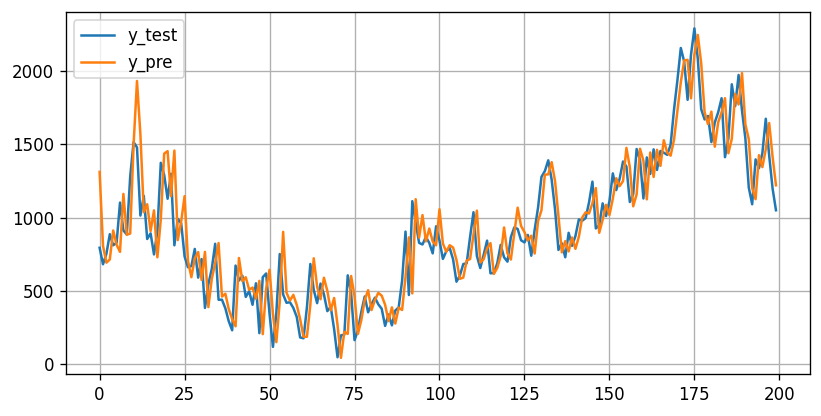

In [31]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_xgboost[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

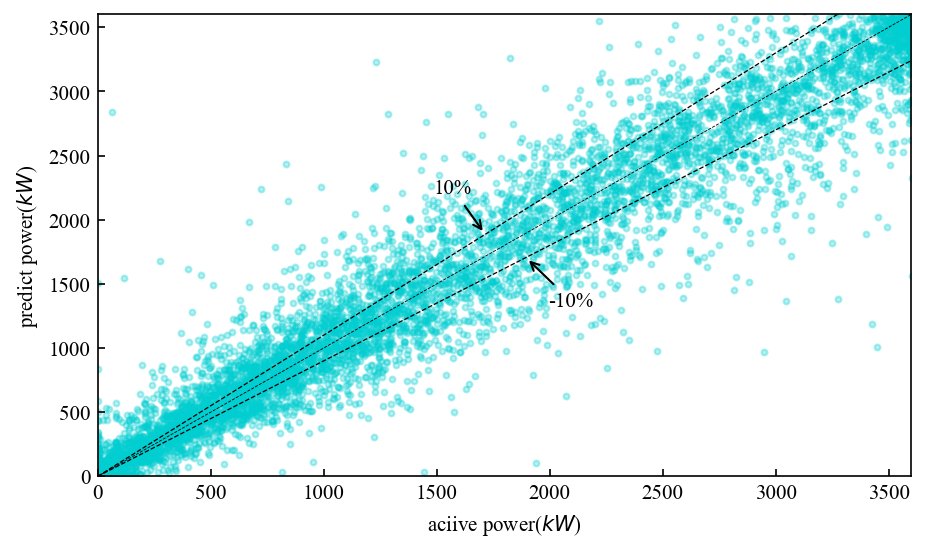

In [32]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_xgboost)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/xgboost预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [29]:
print('mse:', mse(y_test_inverse, prediction_xgboost))
print('rmse', rmse(y_test_inverse, prediction_xgboost))
print('mae', mae(y_test_inverse, prediction_xgboost))
print('mape', mape(y_test_inverse, prediction_xgboost))
print('smape', smape(y_test_inverse, prediction_xgboost))
print('r2', r2(y_test_inverse, prediction_xgboost))

mse: 62482.72839088555
rmse 249.96545439497345
mae 146.11380140008947
mape inf
smape 56.876813948058846
r2 0.9653069790235431


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


## linear regression

### 模型训练

In [57]:
# linear regression
def fit_linear():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=[X_train.shape[1], X_train.shape[2]]),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam(0.01))
    model.fit(X_train,y_train,epochs=20,verbose=1)
    return model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


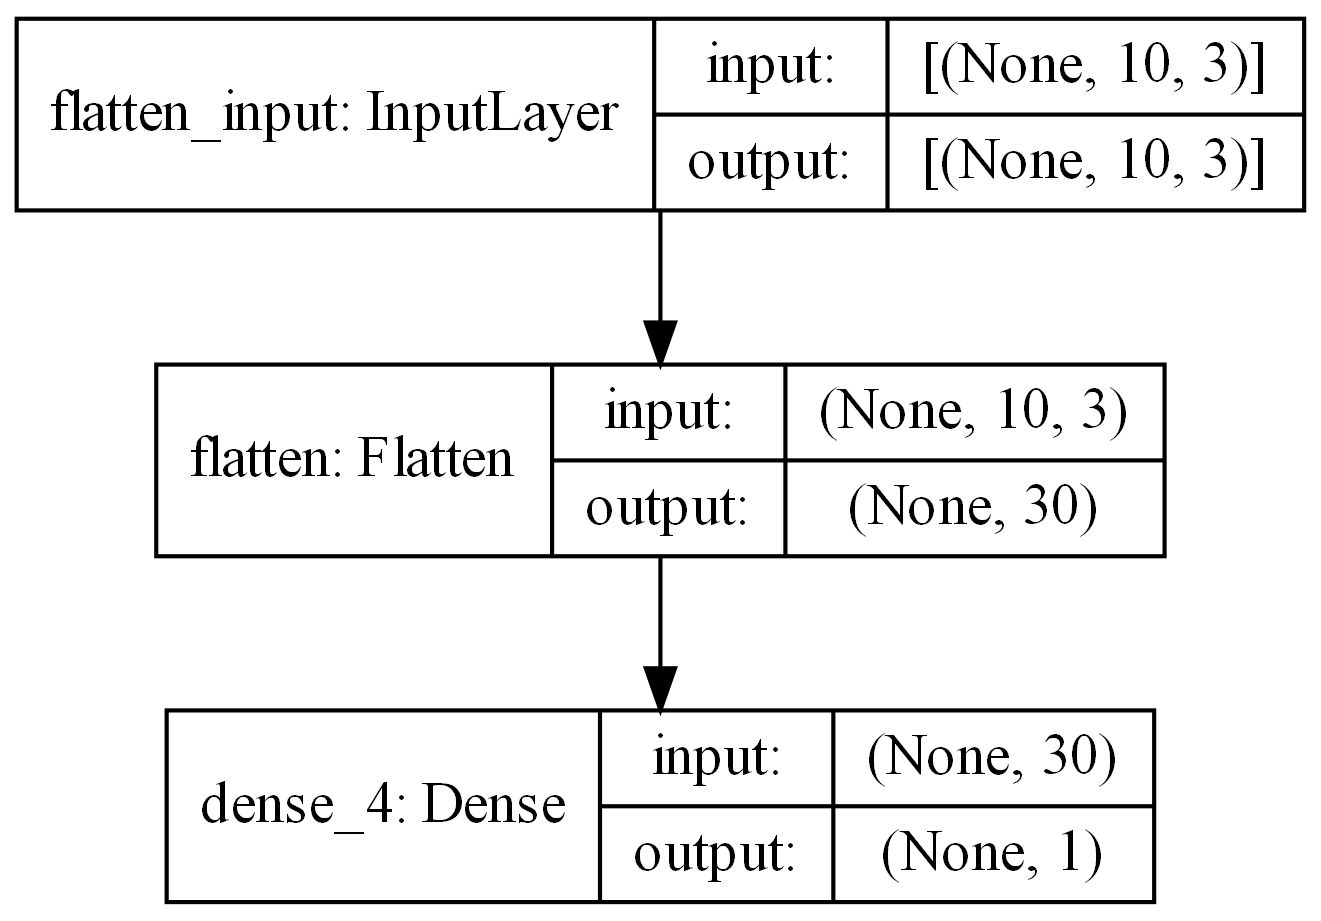

In [65]:
model_linear.summary()
tf.keras.utils.plot_model(model, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/linear-regression结构.png', dpi=300)

In [58]:
model_linear = fit_linear()
model_linear.evaluate(X_test,y_test)

Epoch 1/20
1263/1263 [==============================] - 1s 935us/step - loss: 0.0122 0s - loss: 
Epoch 2/20
1263/1263 [==============================] - 1s 792us/step - loss: 0.0051
Epoch 3/20
1263/1263 [==============================] - 1s 778us/step - loss: 0.0052
Epoch 4/20
1263/1263 [==============================] - 1s 808us/step - loss: 0.0052
Epoch 5/20
1263/1263 [==============================] - 1s 909us/step - loss: 0.0051
Epoch 6/20
1263/1263 [==============================] - 1s 866us/step - loss: 0.0052
Epoch 7/20
1263/1263 [==============================] - 1s 837us/step - loss: 0.0051
Epoch 8/20
1263/1263 [==============================] - 1s 832us/step - loss: 0.0052
Epoch 9/20
1263/1263 [==============================] - 1s 811us/step - loss: 0.0051
Epoch 10/20
1263/1263 [==============================] - 1s 795us/step - loss: 0.0052
Epoch 11/20
1263/1263 [==============================] - 1s 801us/step - loss: 0.0052
Epoch 12/20
1263/1263 [============================

0.0042757317423820496

### 预测结果展示

In [59]:
prediction_linear = model_linear.predict(X_test)
prediction_linear = inverse_transform_col(scaler, prediction_linear, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_linear = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_linear[:,0]})
df_linear.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/linear-regression/prediction_linear.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

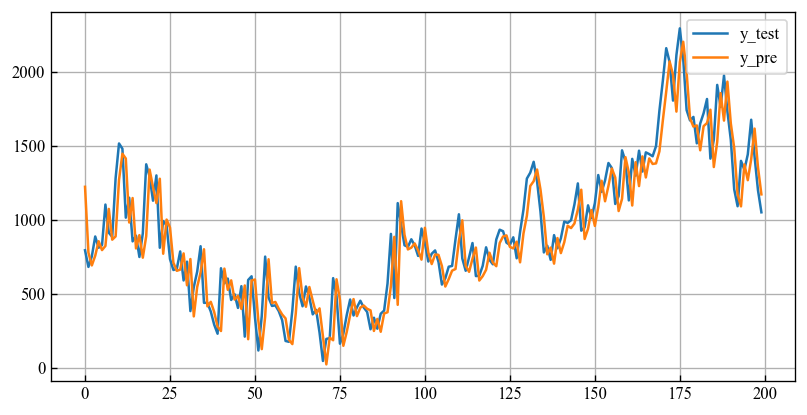

In [60]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_linear[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

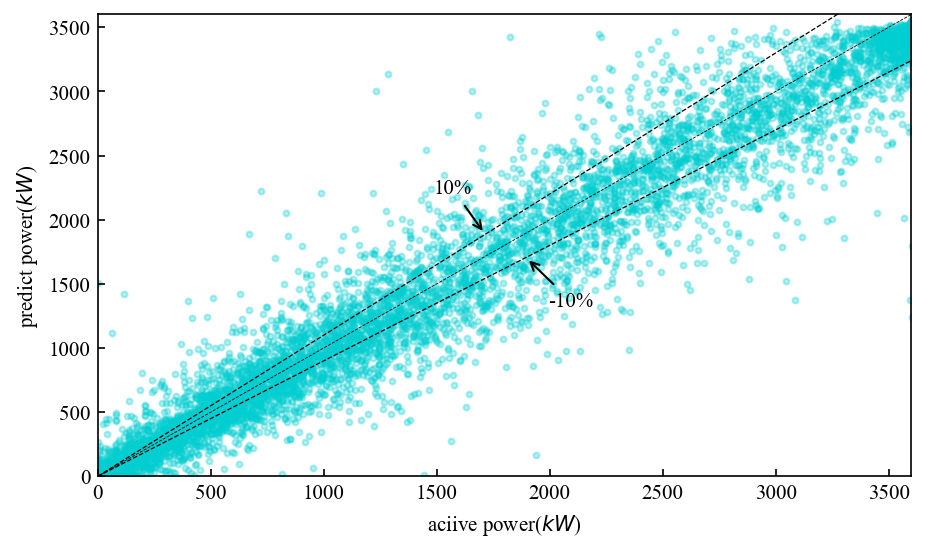

In [61]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_linear)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/线性回归预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [63]:
print('mse:', mse(y_test_inverse,prediction_linear[:,0]))
print('rmse', rmse(y_test_inverse,prediction_linear[:,0]))
print('mae', mae(y_test_inverse,prediction_linear[:,0]))
print('mape', mape(y_test_inverse,prediction_linear[:,0]))
print('smape', smape(y_test_inverse,prediction_linear[:,0]))
print('r2', r2(y_test_inverse,prediction_linear[:,0]))

mse: 56068.18074270424
rmse 236.7872056144593
mae 151.72260777140912
mape inf
smape 57.978111936299506
r2 0.9688686038412152


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


## simple RNN

### 模型训练

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1011/1011 [==============================] - 4s 3ms/step - loss: 0.0169 - val_loss: 0.0080
Epoch 2/100
1011/1011 [==============================] - 3s 3ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 3/100
1011/1011 [==============================] - 3s 3ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 4/100
1011/1011 [==============================] - 3s 3ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 5/100
1011/1011 [==============================] - 3s 3ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 6/100
1011/1011 [==============================] - 3s 3ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 7/100
1011/1011 [============

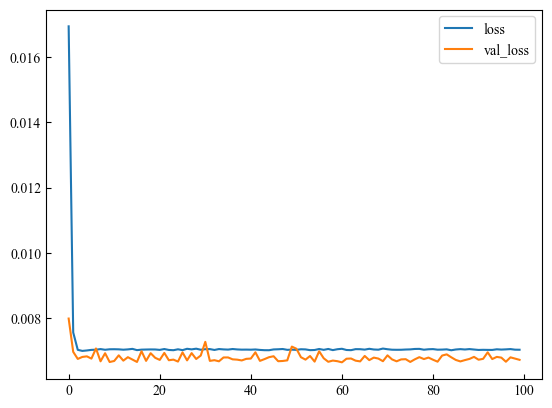

In [83]:
# simple RNN
def fit_simpleRNN(epochs=20):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(1, input_shape=[X_train.shape[1], X_train.shape[2]])
    ])
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(0.01))
    # 生成网络结构图
    model.summary()  # 将信息打印到屏幕终端
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/simpleRNN结构.png', dpi=300)
    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_split=0.2)
    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig('D:/storage_hot/project/output/wind-turbine/loss_function_simpleRNN.png', dpi = 300)
    plt.show()
    return model

model_simpleRNN = fit_simpleRNN(epochs=100)

### 预测结果展示

In [84]:
prediction_simpleRNN = model_simpleRNN.predict(X_test)
prediction_simpleRNN = inverse_transform_col(scaler, prediction_simpleRNN, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_simpleRNN = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_simpleRNN[:,0]})
df_simpleRNN.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/simpleRNN/prediction_simpleRNN.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

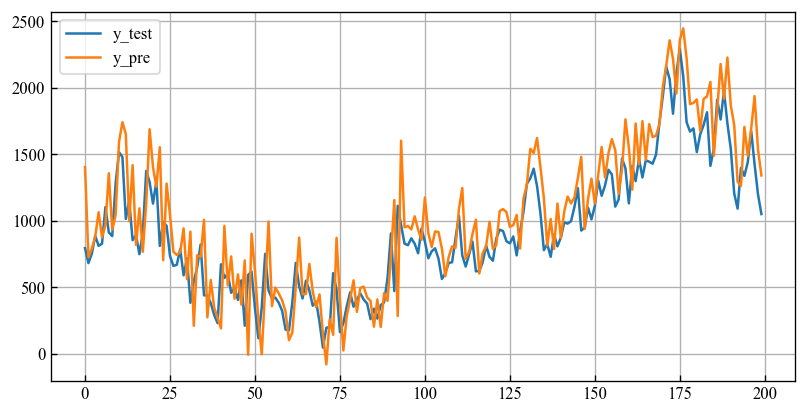

In [85]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_simpleRNN[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

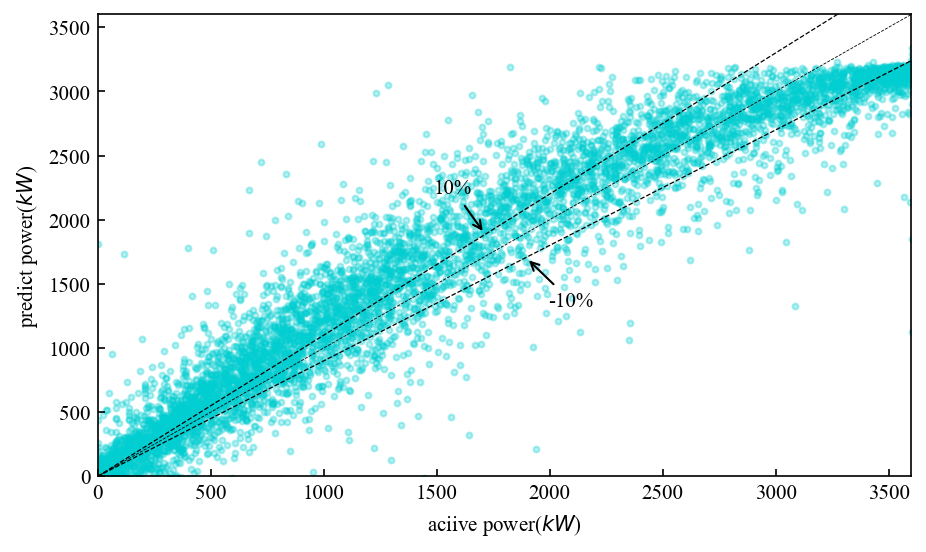

In [86]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_simpleRNN)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/simpleRNN预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [87]:
print('mse:', mse(y_test_inverse,prediction_simpleRNN[:,0]))
print('rmse', rmse(y_test_inverse,prediction_simpleRNN[:,0]))
print('mae', mae(y_test_inverse,prediction_simpleRNN[:,0]))
print('mape', mape(y_test_inverse,prediction_simpleRNN[:,0]))
print('smape', smape(y_test_inverse,prediction_simpleRNN[:,0]))
print('r2', r2(y_test_inverse,prediction_simpleRNN[:,0]))

mse: 91004.6614460508
rmse 301.6697887526207
mae 223.72419001762134
mape inf
smape 62.20768295851795
r2 0.9494704103067986


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


## deep RNN

### 模型训练

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (None, 10, 20)            480       
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 10, 20)            820       
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 20)                820       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 2,141
Trainable params: 2,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1011/1011 [==============================] - 9s 7ms/step - loss: 0.0106 - val_loss: 0.0054
Epoch 2/200
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 3/200
1011/1011 [====================

1011/1011 [==============================] - 6s 6ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 150/200
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 151/200
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 152/200
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 153/200
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 154/200
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 155/200
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 156/200
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 157/200
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 158/200
1011/1011 [==============================] - 6s 6ms/ste

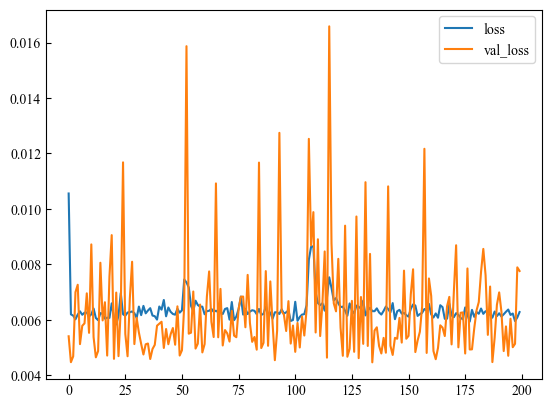

In [96]:
# deep RNN
def fit_RNN(epochs=20):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
        tf.keras.layers.SimpleRNN(20, return_sequences=True),
        tf.keras.layers.SimpleRNN(20),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(0.01))
    # 生成网络结构图
    model.summary()  # 将信息打印到屏幕终端
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/RNN结构.png', dpi=300)
    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_split=0.2)
    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig('D:/storage_hot/project/output/wind-turbine/loss_function_RNN.png', dpi = 300)
    plt.show()
    return model

model_RNN = fit_RNN(epochs=200)

### 预测结果展示

In [97]:
prediction_RNN = model_RNN.predict(X_test)
prediction_RNN = inverse_transform_col(scaler, prediction_RNN, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_simpleRNN = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_RNN[:,0]})
df_simpleRNN.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/RNN/prediction_RNN.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

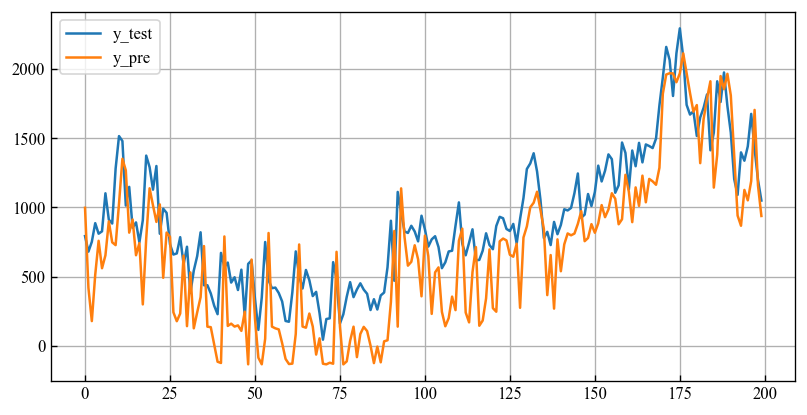

In [98]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_RNN[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

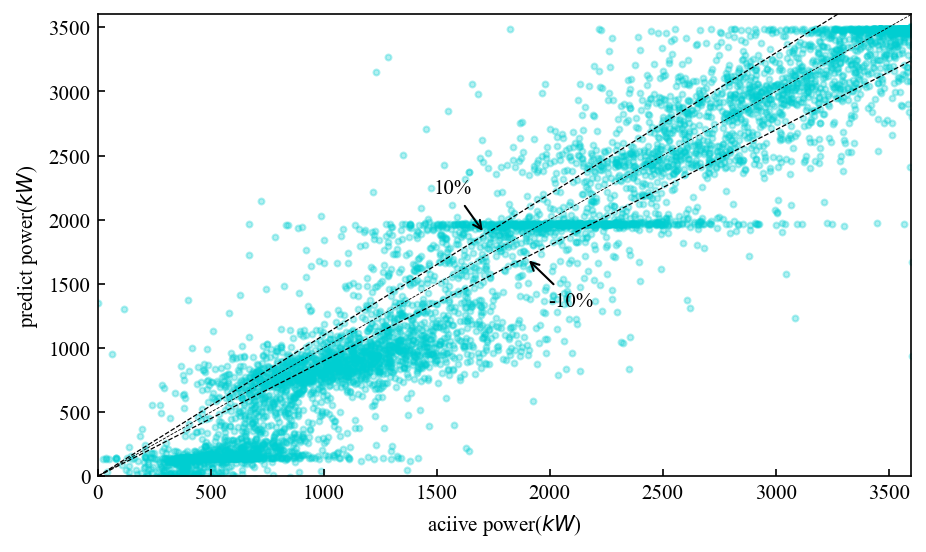

In [99]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_RNN)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/RNN预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [95]:
print('mse:', mse(y_test_inverse,prediction_RNN[:,0]))
print('rmse', rmse(y_test_inverse,prediction_RNN[:,0]))
print('mae', mae(y_test_inverse,prediction_RNN[:,0]))
print('mape', mape(y_test_inverse,prediction_RNN[:,0]))
print('smape', smape(y_test_inverse,prediction_RNN[:,0]))
print('r2', r2(y_test_inverse,prediction_RNN[:,0]))

mse: 96525.29852186755
rmse 310.68520808346756
mae 241.3774489591954
mape inf
smape 59.67809536566554
r2 0.9464051219814147


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


## LSTM

### 模型训练

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 10, 50)            10800     
_________________________________________________________________
dropout_54 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
dropout_55 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_56 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

200/506 [==========>...................] - ETA: 8s - loss: 0.0060 - accuracy: 7.8125e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


298/506 [================>.............] - ETA: 5s - loss: 0.0052 - accuracy: 5.2433e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


400/506 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 7.8125e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


500/506 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 6.2500e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


506/506 [==============================] - 22s 31ms/step - loss: 0.0048 - accuracy: 6.1858e-05 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 2/2
 92/506 [====>.........................] - ETA: 12s - loss: 0.0056 - accuracy: 0.0000e+00WARNING:tensorflow:Can save best model only with val_loss available, skipping.


193/506 [==========>...................] - ETA: 9s - loss: 0.0061 - accuracy: 8.0959e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


294/506 [================>.............] - ETA: 5s - loss: 0.0053 - accuracy: 5.3146e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


394/506 [======================>.......] - ETA: 3s - loss: 0.0052 - accuracy: 7.9315e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


493/506 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 6.3387e-05WARNING:tensorflow:Can save best model only with val_loss available, skipping.


506/506 [==============================] - 15s 29ms/step - loss: 0.0049 - accuracy: 6.1858e-05 - val_loss: 0.0045 - val_accuracy: 0.0000e+00


INFO:tensorflow:Assets written to: ./predict-wind-turbine/LSTM/savedmodel\assets


INFO:tensorflow:Assets written to: ./predict-wind-turbine/LSTM/savedmodel\assets


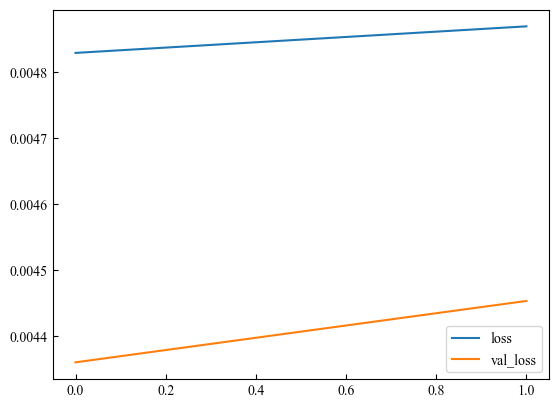

In [107]:
# define LSTM
def fit_LSTM(units=50,epochs=10):    # 神经元数目
    model = Sequential()
    # First layer
    model.add(LSTM(units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Second layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2))
    # Third layer of LSTM
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    
    #Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # 生成网络结构图
    model.summary()  # 将信息打印到屏幕终端
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/LSTM结构.png', dpi=300)  # , to_file='D:/storage/project/output/meiqi/神经网络结构.png'
    
    # set checkpoint 建立检查点，读取已有检查点存储的权重信息
    checkpoint_save_path = "./predict-wind-turbine/LSTM/checkpoint/mnist.ckpt"  # 声明一个ckpt文件存储路径，创建checkpoint文件夹
    if os.path.exists(checkpoint_save_path + '.index'):  # 这里判断是否之前已经存储了模型的训练信息，如果是，则为模型加载之前的参数
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    
    # save model after every epoch
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_save_path,
                                                     save_weights_only = True,save_best_only = True,
                                                     verbose=0, period=5)  # period=10, save_freq=100

    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split = 0.2, verbose=1,
                        shuffle=False, callbacks=[cp_callback])  # 完成训练后保存到检查点, validation_data=(X_test, y_test)；verbose: 0, 1 或 2。日志显示模式。 0 = 安静模式, 1 = 进度条, 2 = 每轮一行
    
    # save model
    model.save("./predict-wind-turbine/LSTM/savedmodel")

    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig('D:/storage_hot/project/output/wind-turbine/loss_function_LSTM.png', dpi = 300)
    plt.show()
    
    return model

model_lstm = fit_LSTM(units=50,epochs=200)

### 预测结果展示

In [ ]:
prediction_lstm = model_lstm.predict(X_test)
prediction_lstm = inverse_transform_col(scaler, prediction_lstm, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_lstm = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_lstm[:,0]})
df_lstm.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/LSTM/prediction_lstm.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

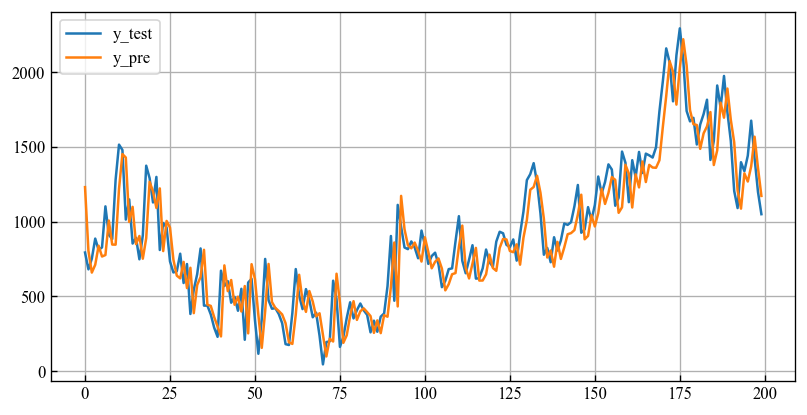

In [135]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_lstm[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

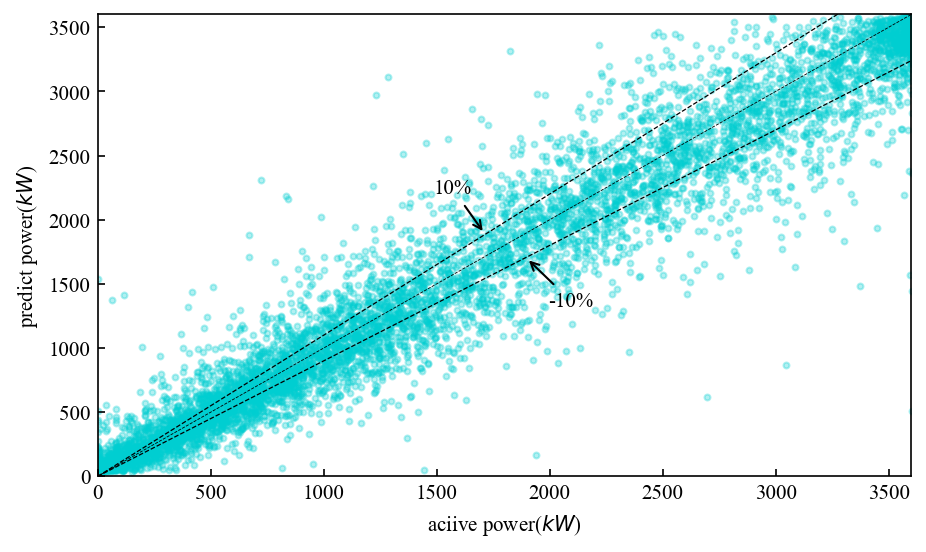

In [137]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_lstm)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/lstm预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [116]:
print('mse:', mse(y_test_inverse,prediction_lstm[:,0]))
print('rmse', rmse(y_test_inverse,prediction_lstm[:,0]))
print('mae', mae(y_test_inverse,prediction_lstm[:,0]))
print('mape', mape(y_test_inverse,prediction_lstm[:,0]))
print('smape', smape(y_test_inverse,prediction_lstm[:,0]))
print('r2', r2(y_test_inverse,prediction_lstm[:,0]))

mse: 58828.2852996019
rmse 242.54542935211518
mae 154.293206216796
mape inf
smape 56.3282757582562
r2 0.9673360784897193


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


```
mse: 57546.25755452272
rmse 239.8880104434624
mae 147.91594798794844
mape inf
smape 56.21112073189101
r2 0.9680479138496316

mse: 56533.81975216778
rmse 237.76841622084245
mae 140.92457994888096
mape inf
smape 56.075034310036585
r2 0.9686100616114054

```

## GRU

### 模型训练

In [43]:
from tensorflow.keras.layers import GRU

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 10, 50)            8250      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 10, 50)            15300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

Epoch 1/10
506/506 [==============================] - 17s 24ms/step - loss: 0.0051 - accuracy: 6.1858e-05 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 2/10
506/506 [==============================] - 10s 20ms/step - loss: 0.0051 - accuracy: 6.1858e-05 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 3/10
506/506 [==============================] - 10s 20ms/step - loss: 0.0052 - accuracy: 6.1858e-05 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 4/10
506/506 [==============================] - 10s 20ms/step - loss: 0.0052 - accuracy: 6.1858e-05 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 5/10
506/506 [==============================] - 10s 20ms/step - loss: 0.0051 - accuracy: 6.1858e-05 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 6/10
506/506 [==============================] - 10s 20ms/step - loss: 0.0051 - accuracy: 6.1858e-05 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 7/10
506/506 [==============================] - 10s 20ms/step - loss: 0.0051 - acc

INFO:tensorflow:Assets written to: ./predict-wind-turbine/GRU/savedmodel\assets


INFO:tensorflow:Assets written to: ./predict-wind-turbine/GRU/savedmodel\assets


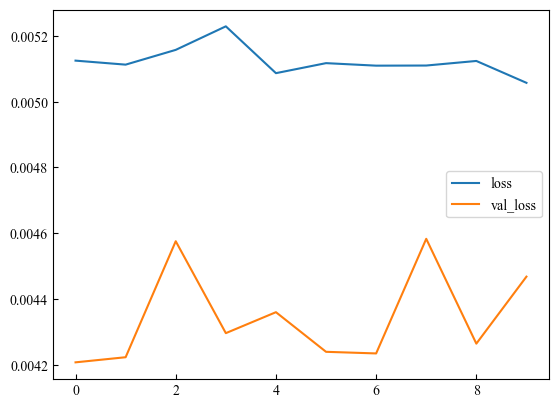

In [46]:
# define GRU
def fit_GRU(units=50,epochs=10):    # 神经元数目
    model = Sequential()
    # First layer
    model.add(GRU(units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Second layer
    model.add(GRU(units = units, return_sequences=True))
    model.add(Dropout(0.2))
    # Third layer
    model.add(GRU(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    
    #Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # 生成网络结构图
    model.summary()  # 将信息打印到屏幕终端
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/GRU结构.png', dpi=300)  # , to_file='D:/storage/project/output/meiqi/神经网络结构.png'
    
    # set checkpoint 建立检查点，读取已有检查点存储的权重信息
    checkpoint_save_path = "./predict-wind-turbine/GRU/checkpoint/mnist.ckpt"  # 声明一个ckpt文件存储路径，创建checkpoint文件夹
    if os.path.exists(checkpoint_save_path + '.index'):  # 这里判断是否之前已经存储了模型的训练信息，如果是，则为模型加载之前的参数
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    
    # save model after every epoch
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_save_path,
                                                     save_weights_only = True,save_best_only = True,
                                                     verbose=0, period=5)  # period=10, save_freq=100

    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split = 0.2, verbose=1,
                        shuffle=False, callbacks=[cp_callback])  # 完成训练后保存到检查点, validation_data=(X_test, y_test)；verbose: 0, 1 或 2。日志显示模式。 0 = 安静模式, 1 = 进度条, 2 = 每轮一行
    
    # save model
    model.save("./predict-wind-turbine/GRU/savedmodel")

    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig('D:/storage_hot/project/output/wind-turbine/loss_function_GRU.png', dpi = 300)
    plt.show()
    
    return model

model_GRU = fit_GRU(units=50,epochs=10)

### 预测结果展示

In [48]:
prediction_GRU = model_GRU.predict(X_test)
prediction_GRU = inverse_transform_col(scaler, prediction_GRU, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_GRU = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_GRU[:,0]})
df_GRU.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/GRU/prediction_GRU.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

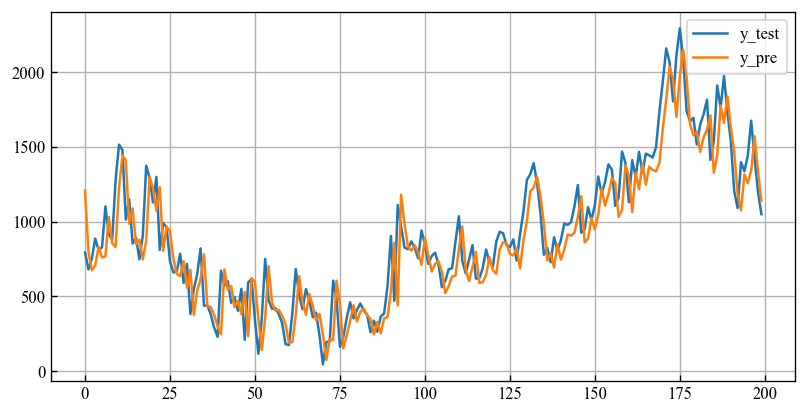

In [49]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_GRU[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

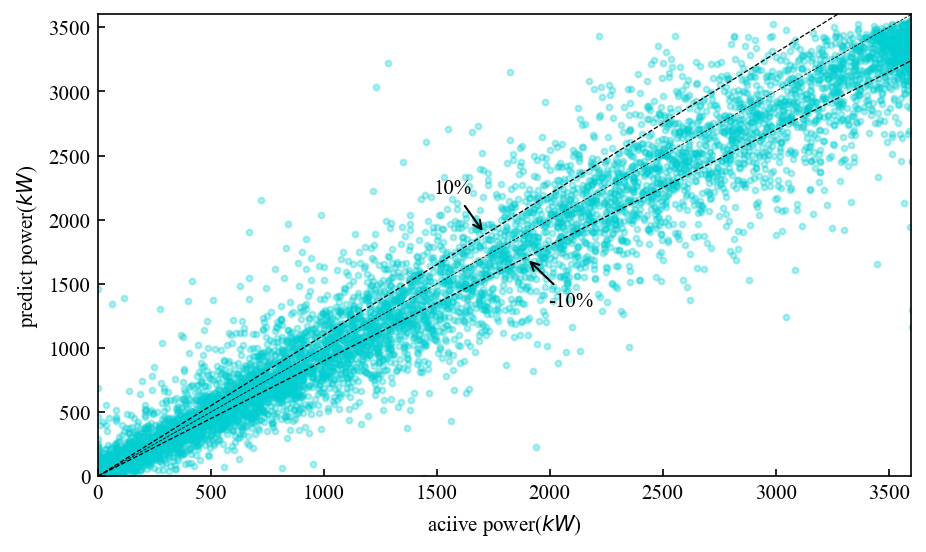

In [50]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_GRU)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/GRU预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [52]:
print('mse:', mse(y_test_inverse,prediction_GRU[:,0]))
print('rmse', rmse(y_test_inverse,prediction_GRU[:,0]))
print('mae', mae(y_test_inverse,prediction_GRU[:,0]))
print('mape', mape(y_test_inverse,prediction_GRU[:,0]))
print('smape', smape(y_test_inverse,prediction_GRU[:,0]))
print('r2', r2(y_test_inverse,prediction_GRU[:,0]))

mse: 60664.97198965506
rmse 246.30260248250536
mae 160.44009127641345
mape inf
smape 56.695203751646986
r2 0.966316273313054


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


```
mse: 60664.97198965506
rmse 246.30260248250536
mae 160.44009127641345
mape inf
smape 56.695203751646986
r2 0.966316273313054
```

## BiLSTM

### 模型训练

Epoch 1/20
506/506 [==============================] - 30s 39ms/step - loss: 0.0201 - accuracy: 3.0929e-05 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 2/20
506/506 [==============================] - 19s 37ms/step - loss: 0.0150 - accuracy: 6.1858e-05 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 3/20
506/506 [==============================] - 16s 33ms/step - loss: 0.0116 - accuracy: 6.1858e-05 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 4/20
506/506 [==============================] - 17s 33ms/step - loss: 0.0094 - accuracy: 6.1858e-05 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 5/20
506/506 [==============================] - 16s 33ms/step - loss: 0.0081 - accuracy: 6.1858e-05 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 6/20
506/506 [==============================] - 17s 33ms/step - loss: 0.0075 - accuracy: 6.1858e-05 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 7/20
506/506 [==============================] - 17s 33ms/step - loss: 0.0069 - acc

INFO:tensorflow:Assets written to: ./predict-wind-turbine/BiLSTM/savedmodel\assets


INFO:tensorflow:Assets written to: ./predict-wind-turbine/BiLSTM/savedmodel\assets


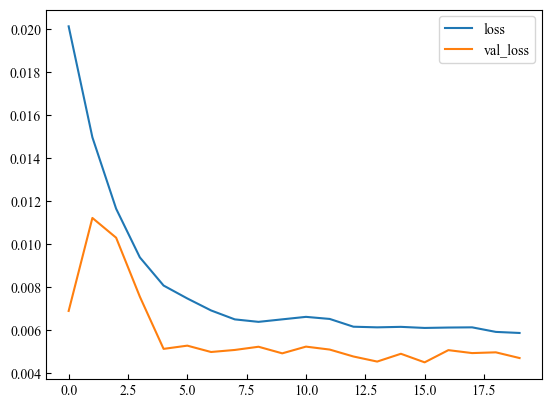

In [37]:
# define BiLSTM
def fit_BiLSTM(units=50,epochs=10):    # 神经元数目
    model = Sequential()
    # First layer
    model.add(Bidirectional(LSTM(units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]])))
    model.add(Dropout(0.2))
    # Second layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True)))
    model.add(Dropout(0.2))
    # Third layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    
    #Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # 生成网络结构图
#     model.summary()  # 将信息打印到屏幕终端
#     tf.keras.utils.plot_model(model, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/BiLSTM结构.png', dpi=300)  # , to_file='D:/storage/project/output/meiqi/神经网络结构.png'
    
    # set checkpoint 建立检查点，读取已有检查点存储的权重信息
    checkpoint_save_path = "./predict-wind-turbine/BiLSTM/checkpoint/mnist.ckpt"  # 声明一个ckpt文件存储路径，创建checkpoint文件夹
    if os.path.exists(checkpoint_save_path + '.index'):  # 这里判断是否之前已经存储了模型的训练信息，如果是，则为模型加载之前的参数
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    
    # save model after every epoch
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_save_path,
                                                     save_weights_only = True,save_best_only = True,
                                                     verbose=0, period=5)  # period=10, save_freq=100

    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split = 0.2, verbose=1,
                        shuffle=False, callbacks=[cp_callback])  # 完成训练后保存到检查点, validation_data=(X_test, y_test)；verbose: 0, 1 或 2。日志显示模式。 0 = 安静模式, 1 = 进度条, 2 = 每轮一行
    
    # save model
    model.save("./predict-wind-turbine/BiLSTM/savedmodel")

    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig('D:/storage_hot/project/output/wind-turbine/loss_function_BiLSTM.png', dpi = 300)
    plt.show()
    
    return model

model_bilstm = fit_BiLSTM(units=50,epochs=20)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 10, 100)           21600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 100)           60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

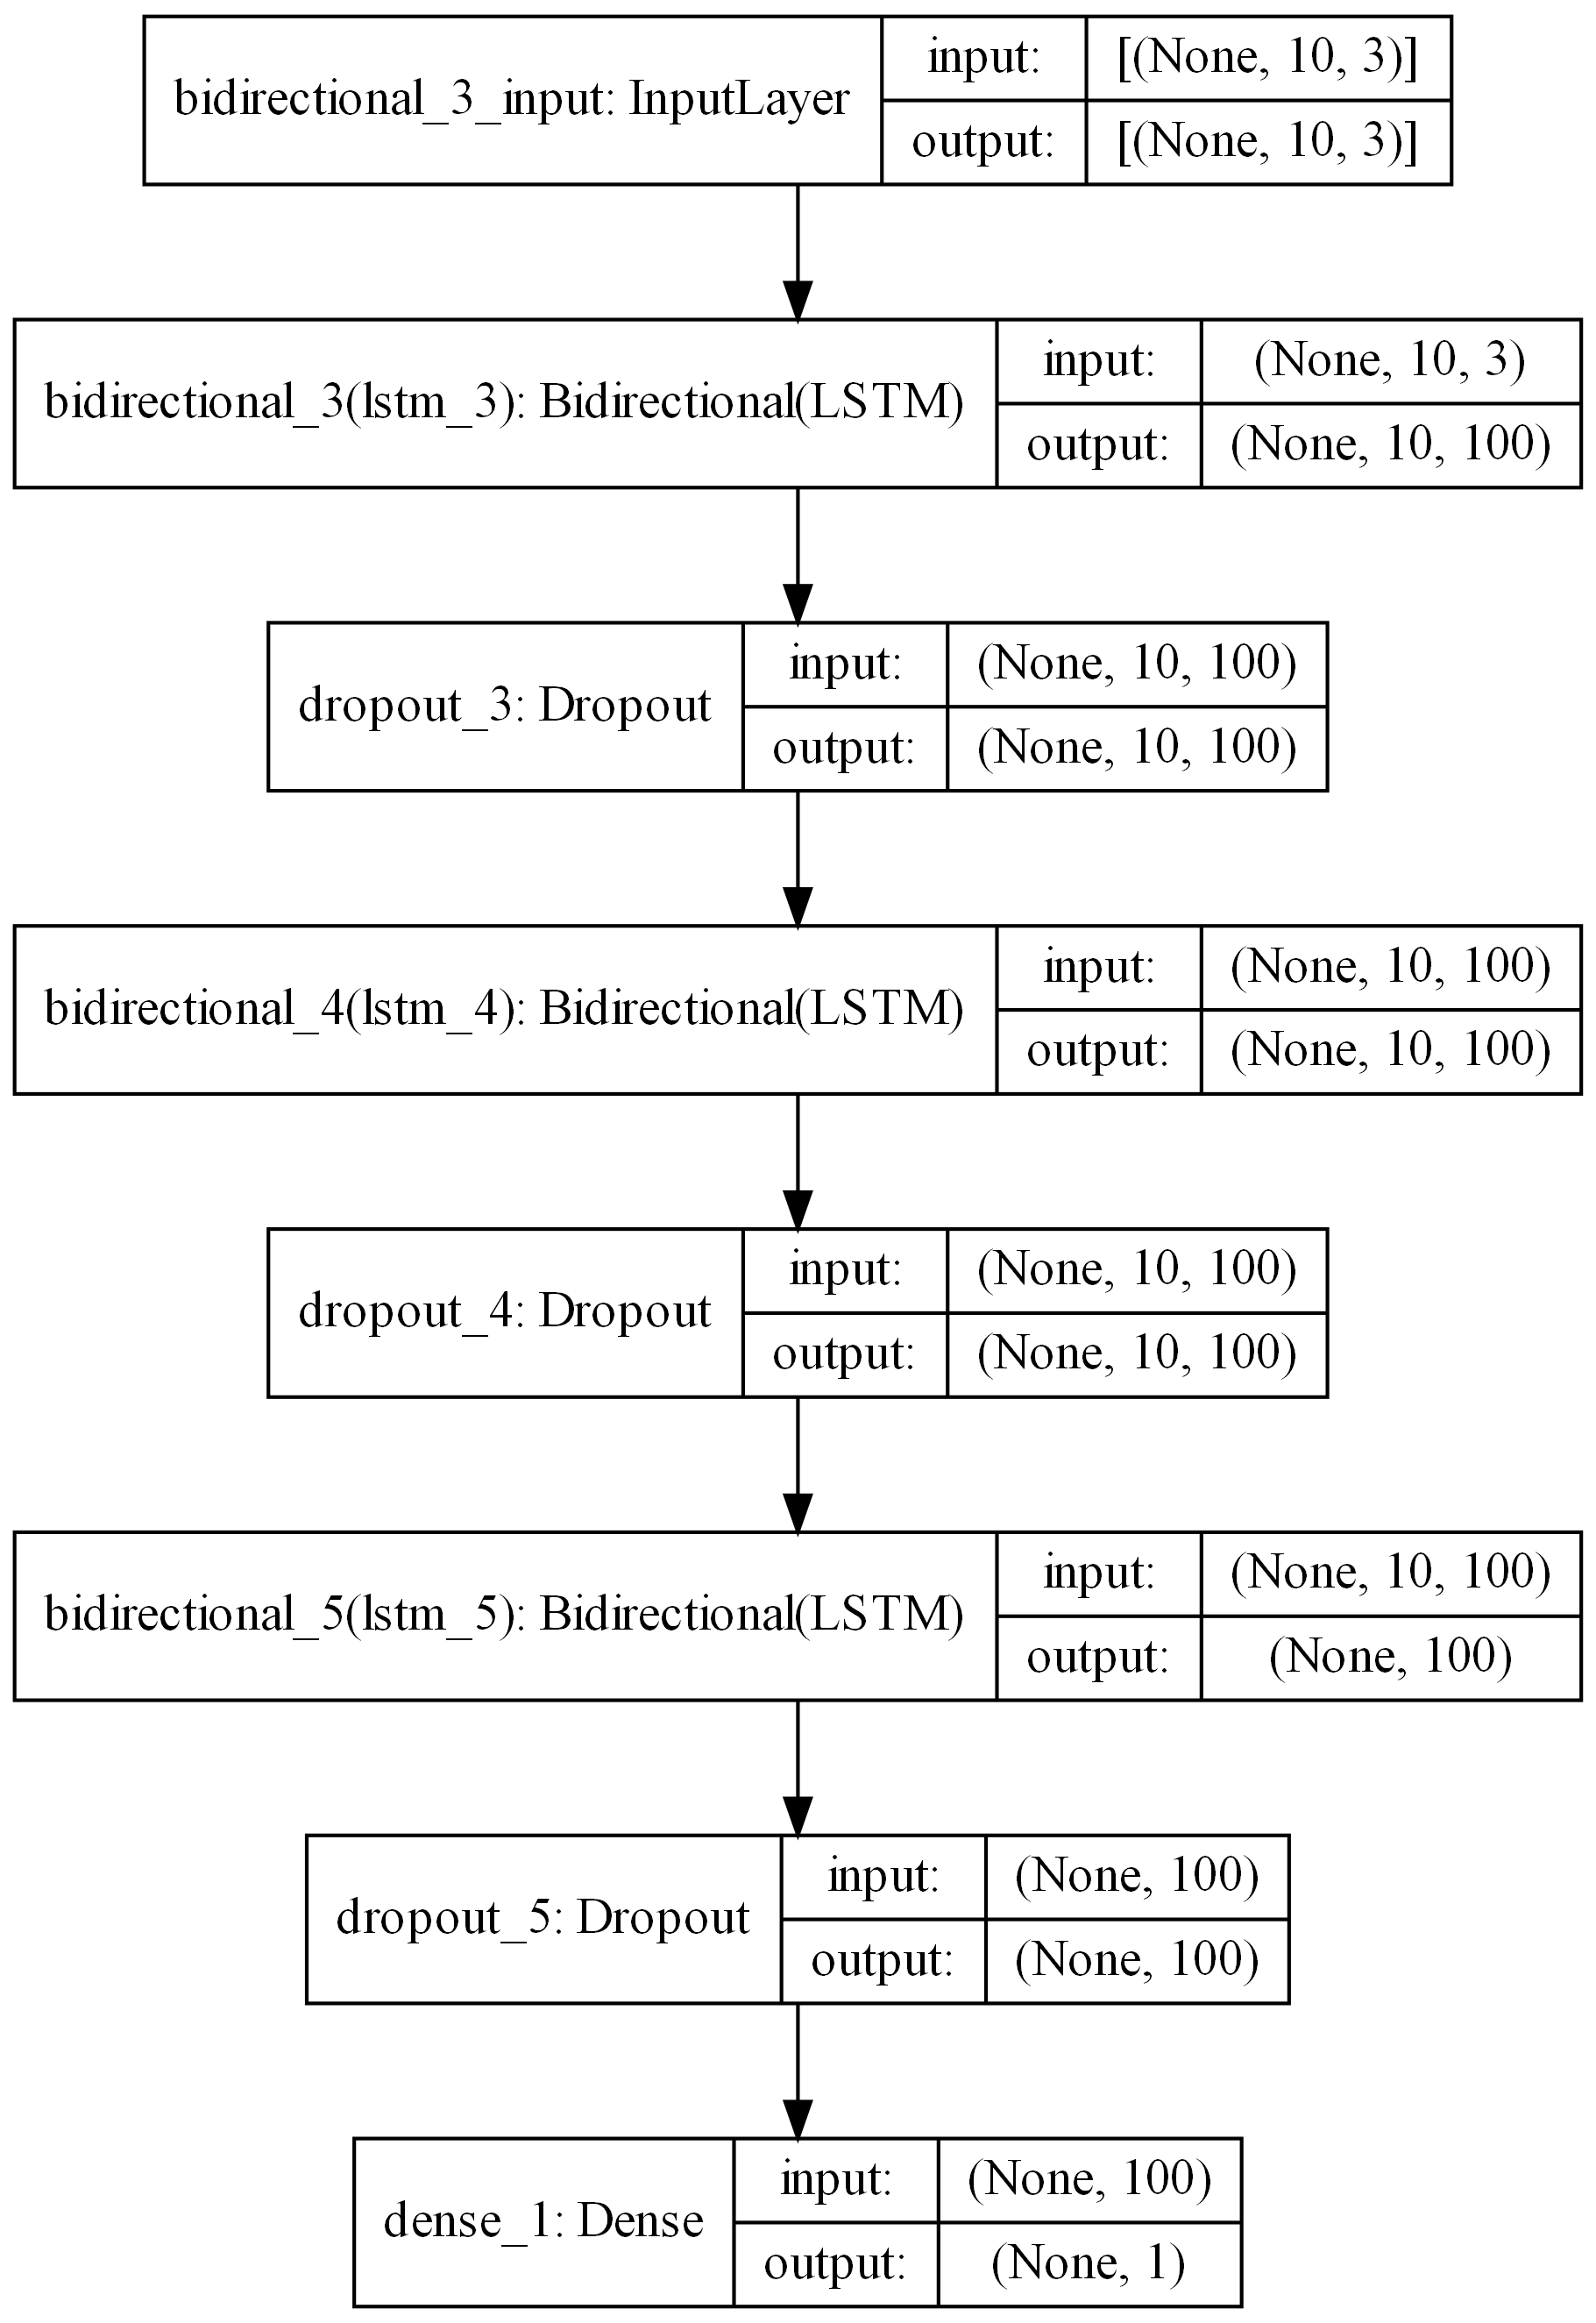

In [67]:
model_bilstm.summary()  # 将信息打印到屏幕终端
tf.keras.utils.plot_model(model_bilstm, show_shapes=True, to_file='D:/storage_hot/project/output/wind-turbine/BiLSTM结构.png', dpi=300)

### 预测结果展示

In [39]:
prediction_bilstm = model_bilstm.predict(X_test)
prediction_bilstm = inverse_transform_col(scaler, prediction_bilstm, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_bilstm = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_bilstm[:,0]})
df_bilstm.to_csv('D:/storage_hot/project/energy_management/predict-wind-turbine/BiLSTM/prediction_bilstm.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

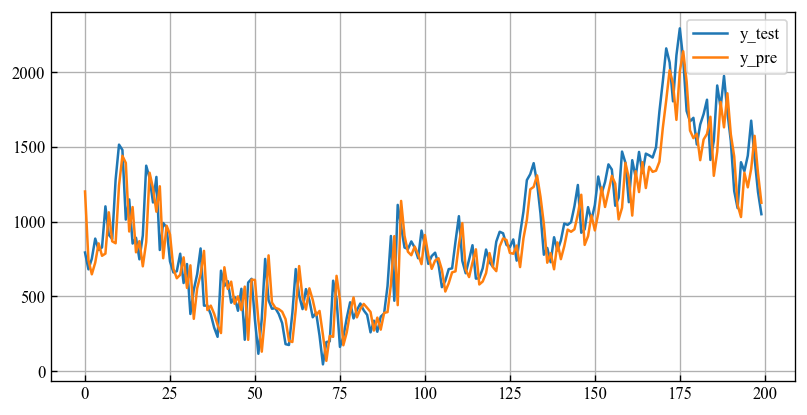

In [40]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_bilstm[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

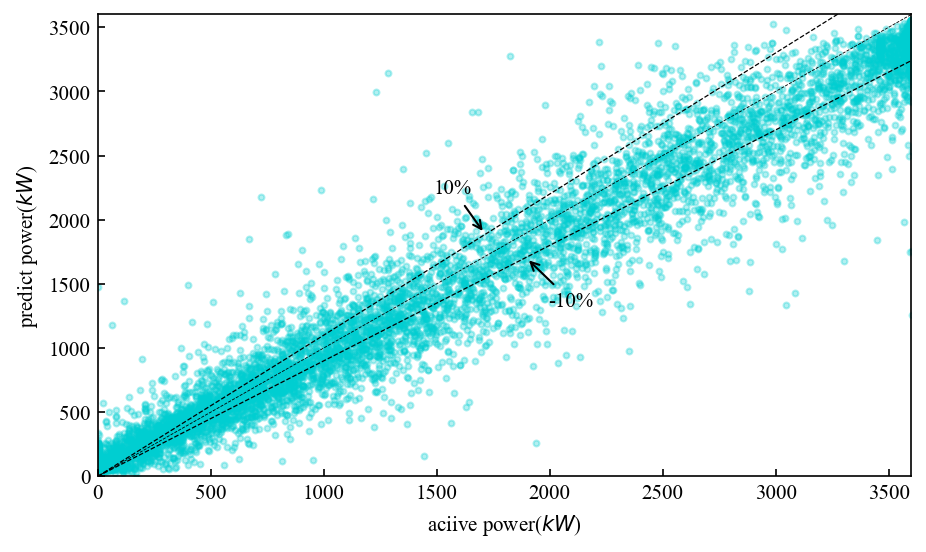

In [41]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_bilstm)
plt.savefig(r'D:/storage_hot/project/output/wind-turbine/bilstm预测散布.png', dpi=300)
plt.show()

### 回归评价指标

In [42]:
print('mse:', mse(y_test_inverse,prediction_bilstm[:,0]))
print('rmse', rmse(y_test_inverse,prediction_bilstm[:,0]))
print('mae', mae(y_test_inverse,prediction_bilstm[:,0]))
print('mape', mape(y_test_inverse,prediction_bilstm[:,0]))
print('smape', smape(y_test_inverse,prediction_bilstm[:,0]))
print('r2', r2(y_test_inverse,prediction_bilstm[:,0]))

mse: 65961.5895043293
rmse 256.82988436770614
mae 176.22039267513122
mape inf
smape 57.452116890807595
r2 0.9633753700062825


C:\Users\Administrator\Desktop\env37_1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


# 加载训练好的模型

In [ ]:
checkpoint_dir = "./predict-wind-turbine/LSTM/savedmodel"
from tensorflow.keras.models import load_model
model = load_model(checkpoint_dir)

In [ ]:
xx, yy = train_scaled[:, :-1], train_scaled[:, -1]  # 按列切片，从起始位置到-2列：-1列
print(xx)

xx, yy = xx[6], [yy[6]]  # yy只是一个数不是向量
yy = np.asarray(yy)
print(xx, '\n', 'yy', yy)
print(len(xx))

xx = xx.reshape((1, n_timesteps, n_features))  # 相当于将每一行变换成一个二维矩阵
print(xx)


y = model.predict(xx)
print('y', y)

# invert scaling for forecast 逆转预测值的缩放 inv_yhat：反转缩放后的预测值
inv_y = inverse_transform_col(scaler, y, 0)  # (比例尺，缩放后的值，比例尺编号)
inv_y = inv_y[:, 0]  # 0列
print(inv_y)

# invert scaling for actual 逆转实际值的缩放 inv_y:测试集的实际值
inv_yy = yy.reshape((len(yy), 1))
inv_yy = inverse_transform_col(scaler, inv_yy, 0)
inv_yy = inv_yy[:, 0]  # 2D第二个维度第一个变量？
print(inv_yy)

# study & test

## subplot()

### 子图创建方式一

subplot(nrows,ncols,index,projection,sharex,sharey)

作用：创建子图。返回值：坐标轴对象。

参数：

- nrows--行数；
- ncols--列数；
- index--子图序号；
- projection--坐标系，默认为直角坐标系，设置为'polar'为极坐标系；
- sharex、sharey--设置各子图间相同的x轴、y轴刻度。

说明：

1.上述参数均可缺省，即仅获得坐标轴对象;

2.行数、列数、序号之间的逗号可省略，例如subplot(2,1,1)等同于subplot(211)。


### 子图创建方式二

subplots(nrows,ncols,sharex,sharey)

作用：创建布局好的矩阵子图。

返回值：fig,ax。

参数：

- nrows--行数；
- ncols--列数；
- sharex--是否共享X轴；默认False不共享，设置为True则共享；
- sharey--是否共享Y轴，默认False不共享，设置为True则共享；

### 子图创建方式三

fig=plt.figure()fig.add_subplot()

说明：上述函数与subplot()函数参数及意义相同。


## subplot 间距

### 子图之间间距调整

subplots_adjust(left,bottom,right,top,wspace,hspace)

作用：调整子图间距。

参数：

- left--图形到左边缘距离；
- bottom--图形到下边缘距离；
- right--图形到右边缘距离；
- top--图形到上边缘距离；
- wspace--各子图间横向间距；
- hspace--各子图间纵向间距；

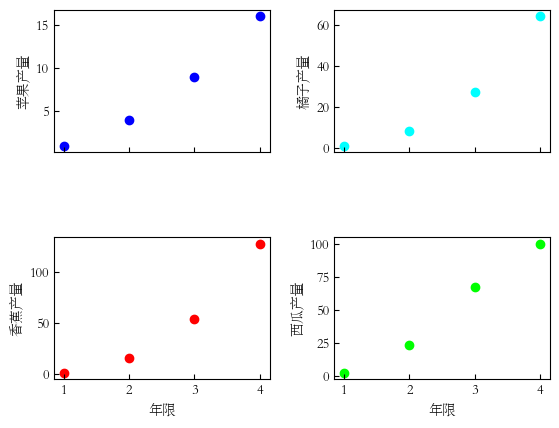

In [67]:
import matplotlib.pyplot as plt

# 数据
x = [1, 2, 3, 4]
apple = [1, 4, 9, 16]
orange = [1, 8, 27, 64]
banana = [1, 16, 54, 128]
watermelon = [2, 23, 67, 100]

plt.rc('font', family='STSong')
fig, ax = plt.subplots(2,2,sharex=True)

# 子图1
ax[0,0].scatter(x, apple, c='blue')
ax[0,0].set_ylabel('苹果产量')

# 子图2
ax[0,1].scatter(x, orange, c='cyan')
ax[0,1].set_ylabel('橘子产量')

# 子图3
ax[1,0].scatter(x, banana, c='red')
ax[1,0].set_ylabel('香蕉产量')
ax[1,0].set_xlabel('年限')

# 子图4
ax[1,1].scatter(x, watermelon,c='lime')
ax[1,1].set_ylabel('西瓜产量')
ax[1,1].set_xlabel('年限')

# 子图间距调整
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()